# How do Hilbert and Z-order SFC algorithms compare in performance regarding expressiveness, accuracy, and TP/FP in 2D acceleration data using vehicle data?

## Import all necessary libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import morton
import matplotlib
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from hilbertcurve.hilbertcurve import HilbertCurve 

## Define functions to manipulate data and plot

In [2]:
offset = 10
faktor_multiply = 10000

def add_offset(df):
    df['accel_lon'] = df['accel_lon'].add(offset)
    df['accel_lat'] = df['accel_lat'].add(offset)
    df['accel_lon'] = df.apply(lambda x: int(x['accel_lon']*faktor_multiply) , axis=1)
    df['accel_lat'] = df.apply(lambda x: int(x['accel_lat']*faktor_multiply) , axis=1)

In [3]:
morton = morton.Morton(dimensions=2, bits=18)

def set_morton_value(row):
    return morton.pack(int(row['accel_lon']), int(row['accel_lat']))

In [4]:
resolution = 26; dimension = 2
hilbert = HilbertCurve(resolution, dimension, n_procs=-1)

def set_hilbert_value(df):
    points = df[['accel_lon','accel_lat']].to_numpy()
    distances = hilbert.distances_from_points(points)
    return pd.concat([df, pd.DataFrame(distances, columns = ['hilbert'] )], axis=1)

In [5]:
def normalize_column (df, column):
    df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())

In [6]:
def average_calculator (df, column, part_number):
    mean_list = []
    df_parts = np.array_split(df, part_number)

    # calculate the average value of the 'values' column for each part
    for i, part in enumerate(df_parts):
        avg_value = part[column].mean()
        mean_list.append(avg_value)
    return mean_list

In [7]:
def ra_range_detector(number):
    ranges = [(1584855907826492, 1584855957057419), 
              (1584855801534728, 1584855834264867), 
              (1584855550099753, 1584855572010558), 
              (1584855456558058, 1584855474498497), 
              (1584853465258107, 1584853495138141), 
              (1584853829083708, 1584853864063504), 
              (1584853141014223, 1584853161994578)] 
    
   

    for i, r in enumerate(ranges):
        if number >= (r[0]-500) and number <= (r[1]+500):
            print(f"{number} is in range {i}: {r}")


In [8]:
def correlation_calculator(array1, array2, degree):
    p = np.polyfit(range(len(array1)), array2, degree)
    fitted_array1 = np.polyval(p, range(len(array1)))

    # Calculate the correlation between the fitted polynomial and array2
    correlation = np.corrcoef(fitted_array1, array2)[0, 1]
    return correlation 


In [9]:
# this is only for debugging purposes and will be removed
def plot_sfc_2d(df, column):
    min = df[column].min()
    max = df[column].max()
    fig, ax = plt.subplots()
    ax.hist(df[column], bins=200)
    ax.set_ylim([0,1])
    ax2 = ax.twinx()

    ax2.scatter(x=df[column],y=df['ts'], c='red', s=2)
    ax.set_xlabel(column)
    ax2.set_ylabel('ts')
    plt.xlim(min, max)
    plt.show()

## Import data from csv files

In [10]:
acc_data =  pd.read_csv ('../SnowFox-Roundabout-Dataset/data/Vehicle-IMU-Acceleration-10Hz.csv', sep=';', usecols = ['sampleTimeStamp.seconds','sampleTimeStamp.microseconds','IMULatAcceleration', 'IMULgtAcceleration', 'IMUVerAcceleration'])
acc_data['ts'] = (acc_data['sampleTimeStamp.seconds']*1000000) + acc_data['sampleTimeStamp.microseconds']
acc_data = acc_data.drop(columns=['sampleTimeStamp.seconds', 'sampleTimeStamp.microseconds'])
acc_data = acc_data.rename(columns={'IMULatAcceleration': 'accel_lat', 'IMULgtAcceleration': 'accel_lon', 'IMUVerAcceleration': 'accel_ver'})

## Normalize a copy of df to compare

In [11]:
acc_data_normalized = acc_data.copy()
normalize_column(acc_data_normalized, 'accel_lat')
normalize_column(acc_data_normalized, 'accel_lon')

## Calculate Hilbert and Morton values of each df

In [12]:
add_offset(acc_data)
add_offset(acc_data_normalized)

In [13]:
acc_data['morton'] = acc_data.apply(set_morton_value, axis=1)
acc_data_normalized['morton'] = acc_data_normalized.apply(set_morton_value, axis=1)

In [14]:
acc_data = set_hilbert_value(acc_data)
acc_data_normalized = set_hilbert_value(acc_data_normalized)

In [15]:
acc_data

accel_lat  accel_lon  accel_ver                ts       morton   
0         103655     100085     9.6390  1584853114144056  16143154491  \
1         103059     100254     9.6135  1584853114244214  16141632350   
2         103145     100595     9.6390  1584853114343862  16144465287   
3         103485     100935     9.6390  1584853114444137  16146242231   
4         103995     100425     9.6815  1584853114544210  16146504395   
...          ...        ...        ...               ...          ...   
33933     100085      99235     9.6815  1584856523117558  16109137447   
33934      99915      99065     9.7155  1584856523217344  16109041099   
33935      99745      99235     9.6645  1584856523317244  16108735495   
33936      99745      99065     9.6645  1584856523417580  16108674371   
33937      99915      99065     9.6390  1584856523517339  16109041099   

           hilbert  
0      10796968230  
1      10797417209  
2      10794871662  
3      10795360206  
4      10796048164  
...            ...  
33933  10740799796  
33934  10740756364  
33935  10740834990  
33936  10741061954  
33937  10740756364  

[33938 rows x 6 columns]

In [16]:
acc_data_normalized

accel_lat  accel_lon  accel_ver                ts       morton   
0         105162     106208     9.6390  1584853114144056  16170939528  \
1         105078     106235     9.6135  1584853114244214  16170909549   
2         105090     106287     9.6390  1584853114343862  16170976349   
3         105138     106340     9.6390  1584853114444137  16170982936   
4         105210     106261     9.6815  1584853114544210  16170986393   
...          ...        ...        ...               ...          ...   
33933     104657     106076     9.6815  1584856523117558  16170398546   
33934     104632     106050     9.7155  1584856523217344  16170392196   
33935     104608     106076     9.6645  1584856523317244  16170391888   
33936     104608     106050     9.6645  1584856523417580  16170391556   
33937     104632     106050     9.6390  1584856523517339  16170392196   

           hilbert  
0      10780978790  
1      10780983417  
2      10781058643  
3      10781053364  
4      10781064311  
...            ...  
33933  10780697169  
33934  10780702060  
33935  10780702704  
33936  10780702380  
33937  10780702060  

[33938 rows x 6 columns]

## Get the timestamps for each detected roundabout using te algorithm

In [17]:
## To be added ...

In [18]:
# from the reference roundabout data
ref_ra_start = 1584853829083708
ref_ra_end = 1584853864063504

In [19]:
chunk_size = len(acc_data[(acc_data['ts'] >= ref_ra_start) & (acc_data['ts'] <= ref_ra_end)])
acc_data_size = len(acc_data)

In [20]:
ref_ra = acc_data[(acc_data['ts'] >= ref_ra_start) & (acc_data['ts'] <= ref_ra_end)]
ref_ra_normalized = acc_data_normalized[(acc_data_normalized['ts'] >= ref_ra_start) & (acc_data_normalized['ts'] <= ref_ra_end)]

In [21]:
ref_morton = average_calculator(ref_ra, 'morton', 5)

In [22]:
ref_hilbert = average_calculator(ref_ra, 'hilbert', 5)

In [23]:
ref_norm_morton = average_calculator(ref_ra_normalized, 'morton', 5)

In [24]:
ref_norm_hilbert = average_calculator(ref_ra_normalized, 'hilbert', 5)

### Non-normalized df:

#### Morton

In [24]:
i = 0
roundabout_counter = 0

while i < (acc_data_size - chunk_size) :
    
    sub_ra = acc_data.iloc[i:i+chunk_size, :]
    sub_morton = average_calculator(sub_ra, 'morton', 6)
    correlation = np.corrcoef(sub_morton, ref_morton)[0, 1]
    
    if (correlation > 0.85):  # the pattern match the ref roundabout pattern
        roundabout_counter += 1
        print( acc_data['ts'][i])
        ra_range_detector(acc_data['ts'][i])   
    
    i += 1
#     i += 1
print(roundabout_counter)

1584853139644321
1584853139744478
1584853139844121
1584853139944321
1584853140044473
1584853140144130
1584853140244303
1584853140344452
1584853140444164
1584853140544309
1584853140644462
1584853140744124
1584853140844339
1584853140944490
1584853141044154
1584853141044154 is in range 6: (1584853141014223, 1584853161994578)
1584853141144304
1584853141144304 is in range 6: (1584853141014223, 1584853161994578)
1584853141244475
1584853141244475 is in range 6: (1584853141014223, 1584853161994578)
1584853141344147
1584853141344147 is in range 6: (1584853141014223, 1584853161994578)
1584853141444323
1584853141444323 is in range 6: (1584853141014223, 1584853161994578)
1584853141544489
1584853141544489 is in range 6: (1584853141014223, 1584853161994578)
1584853141644156
1584853141644156 is in range 6: (1584853141014223, 1584853161994578)
1584853141744320
1584853141744320 is in range 6: (1584853141014223, 1584853161994578)
1584853141844467
1584853141844467 is in range 6: (1584853141014223, 158485

1584854205887979
1584854205987625
1584854206087951
1584854206188001
1584854206287605
1584854206387903
1584854206487994
1584854206587582
1584854206687916
1584854206817643
1584854206917998
1584854207018024
1584854207117668
1584854207218016
1584854207318021
1584854207417681
1584854207518026
1584854207617790
1584854207717664
1584854207818007
1584854207958160
1584854208058253
1584854208157992
1584854208268021
1584854208377803
1584854208477713
1584854208578052
1584854208677832
1584854208777744
1584854208878057
1584854208977829
1584854209077721
1584854209178037
1584854209277818
1584854209377745
1584854222608491
1584854222708227
1584854222808346
1584854295679375
1584854295779150
1584854295879613
1584854295979232
1584854296079160
1584854296179362
1584854296279251
1584854296379221
1584854296479624
1584854296579413
1584854296679174
1584854296779615
1584854296879196
1584854296979173
1584854297079641
1584854297179274
1584854297279184
1584854342390079
1584854342489678
1584854342590046
15848543426900

1584855494489160
1584855494588793
1584855494689114
1584855494789140
1584855494888820
1584855494989143
1584855495089177
1584855495188814
1584855495289158
1584855495389172
1584855495488811
1584855495589139
1584855495689171
1584855495788830
1584855495889150
1584855495988951
1584855496088896
1584855496189146
1584855496289179
1584855496388841
1584855496489154
1584855555920231
1584855555920231 is in range 2: (1584855550099753, 1584855572010558)
1584855556019970
1584855556019970 is in range 2: (1584855550099753, 1584855572010558)
1584855556120207
1584855556120207 is in range 2: (1584855550099753, 1584855572010558)
1584855556220241
1584855556220241 is in range 2: (1584855550099753, 1584855572010558)
1584855556319956
1584855556319956 is in range 2: (1584855550099753, 1584855572010558)
1584855556420244
1584855556420244 is in range 2: (1584855550099753, 1584855572010558)
1584855556520238
1584855556520238 is in range 2: (1584855550099753, 1584855572010558)
1584855556620015
1584855556620015 is in r

#### Hilbert

1584853124243997


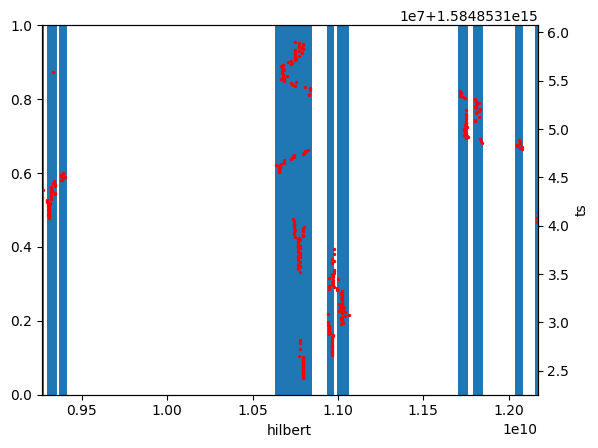

1584853169214574


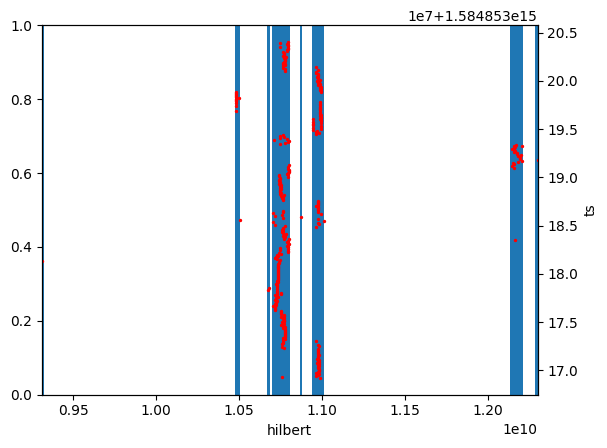

1584853214245023


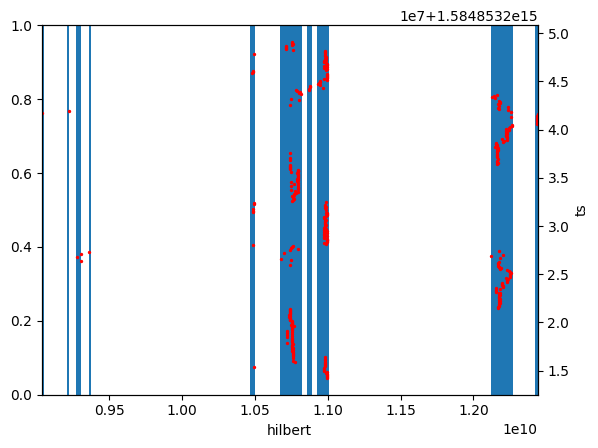

1584853259305227


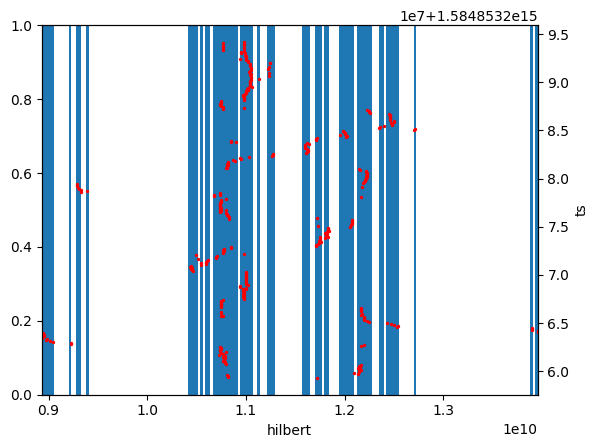

1584853304386006


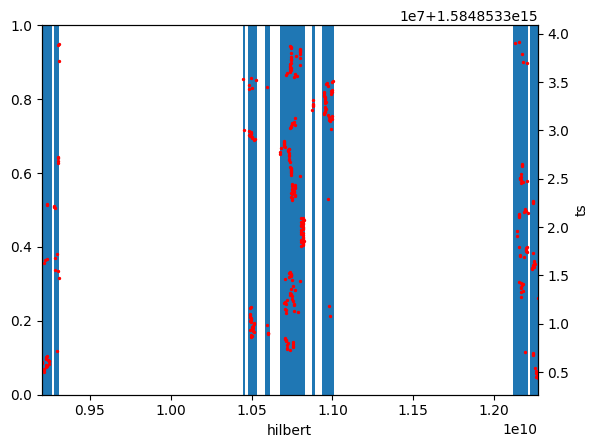

1584853349356451


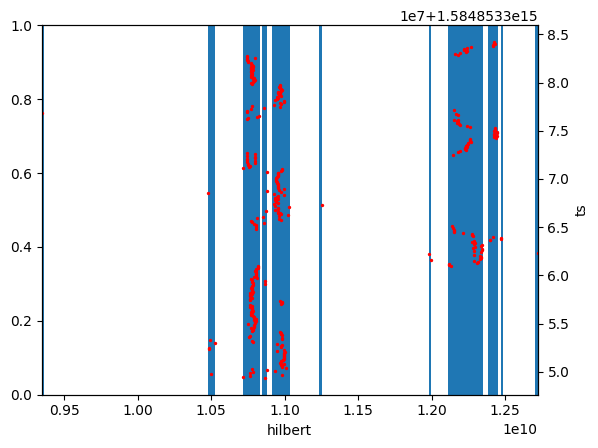

1584853394416863


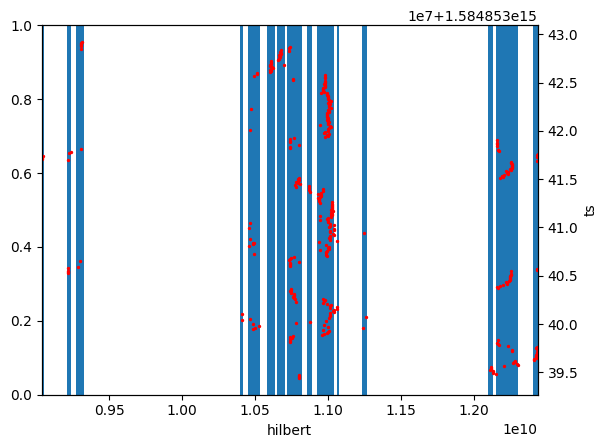

1584853439407326


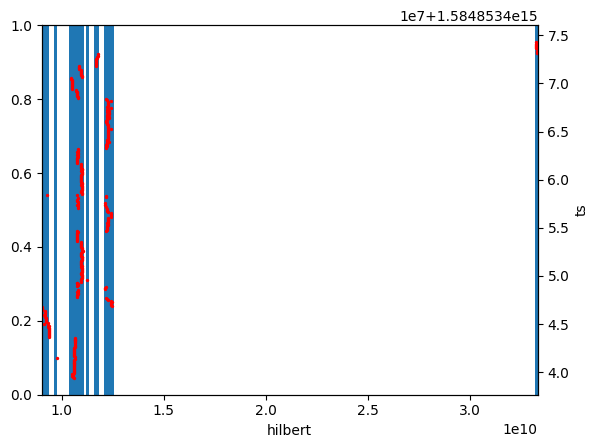

1584853484508041


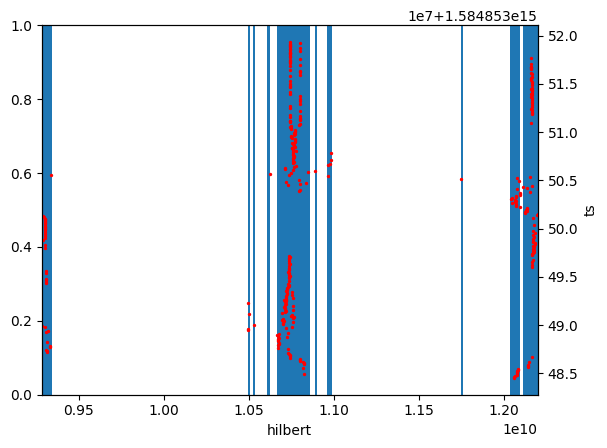

1584853484508041 is in range 4: (1584853465258107, 1584853495138141)
1584853529548678


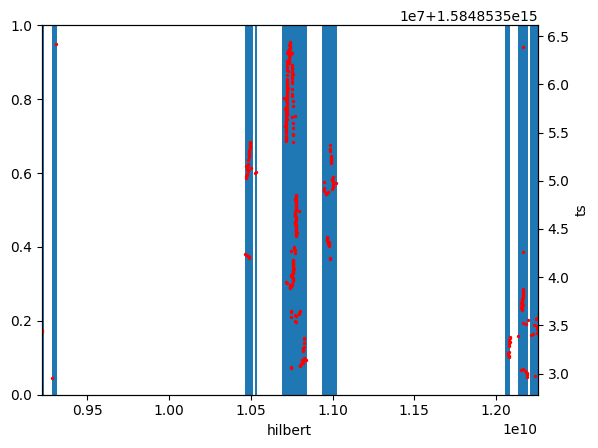

1584853574599391


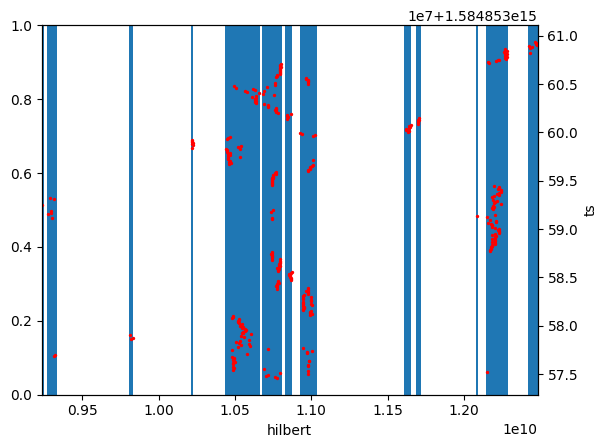

1584853619569495


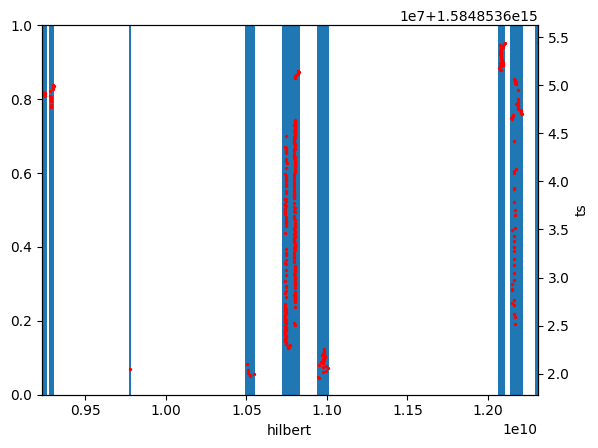

1584853664700468


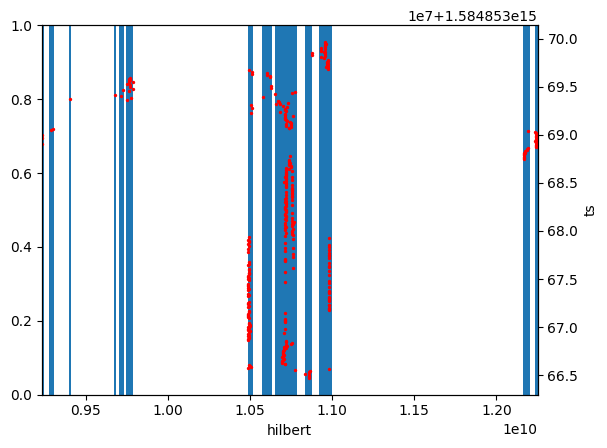

1584853709870718


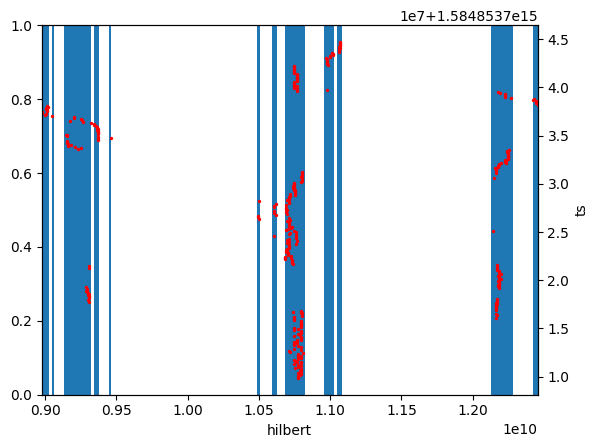

1584853754901771


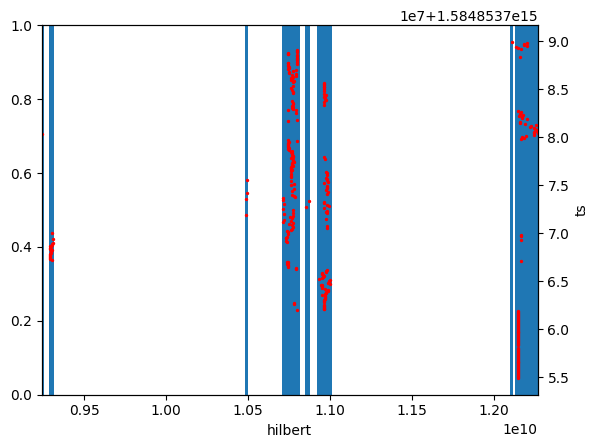

1584853800142437


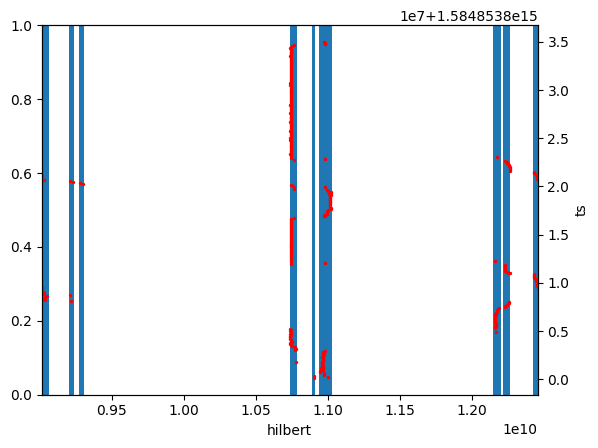

1584853845182859


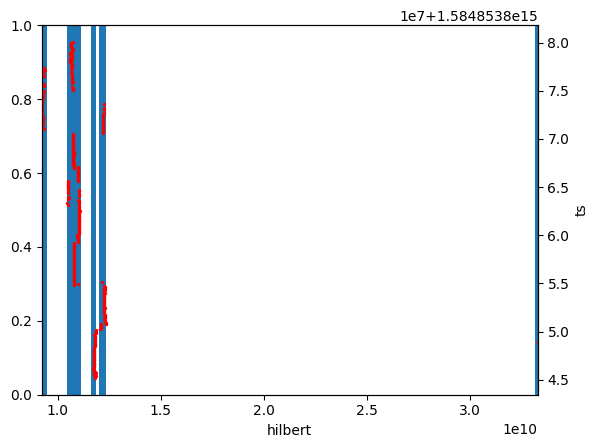

1584853845182859 is in range 5: (1584853829083708, 1584853864063504)
1584853890273398


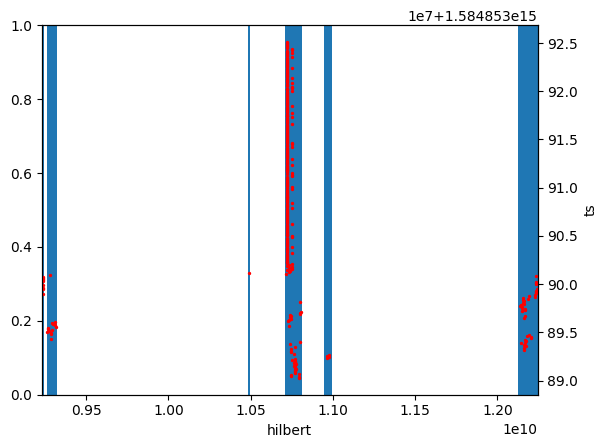

1584853935313781


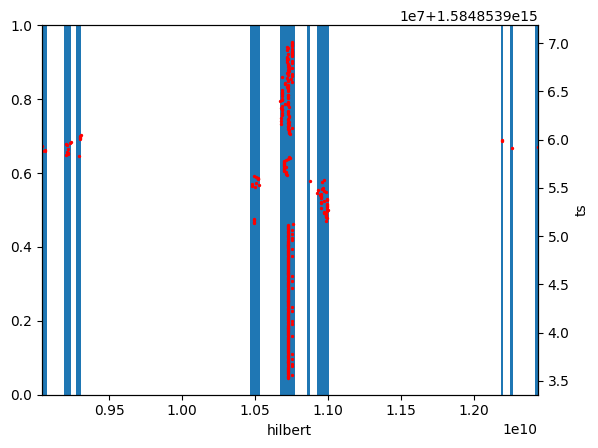

1584853980334747


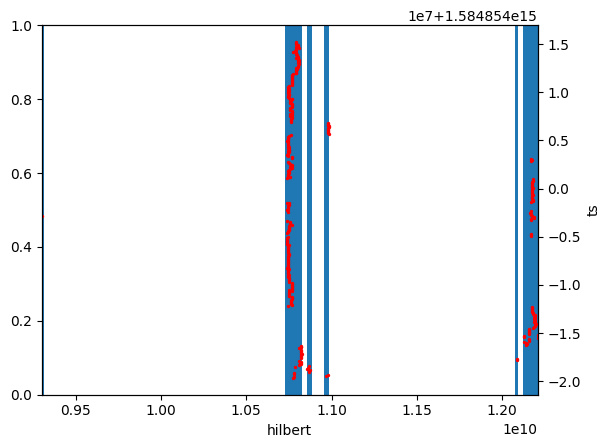

1584854025435327


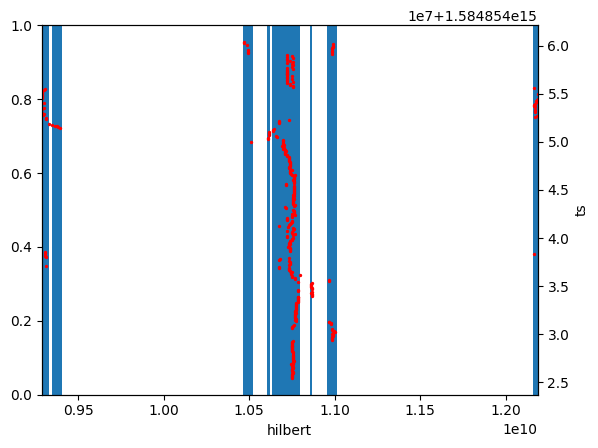

1584854070615660


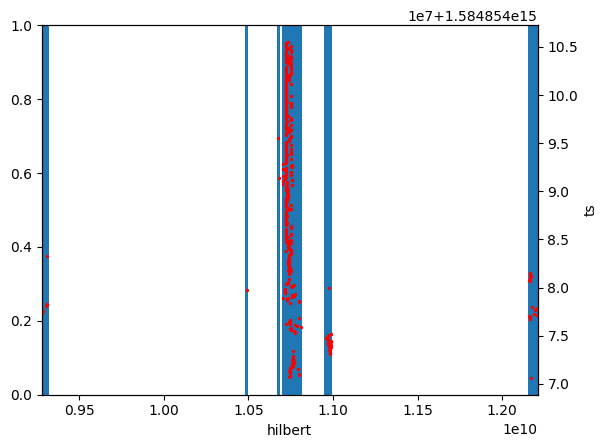

1584854115716638


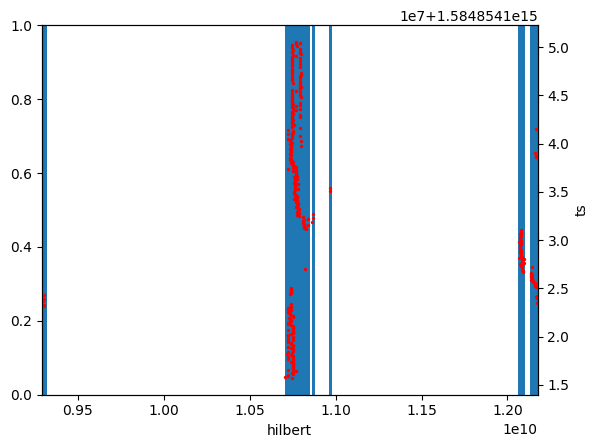

1584854160747117


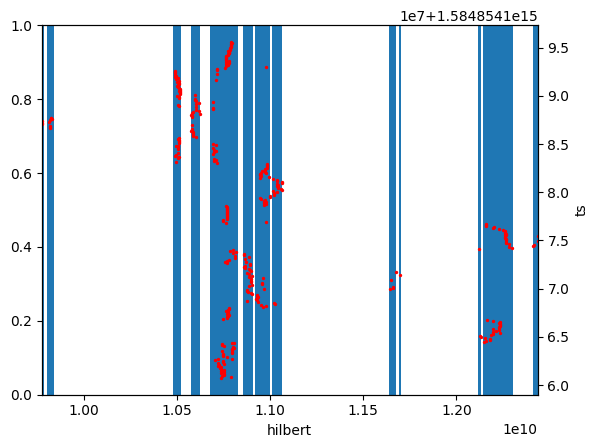

1584854205787880


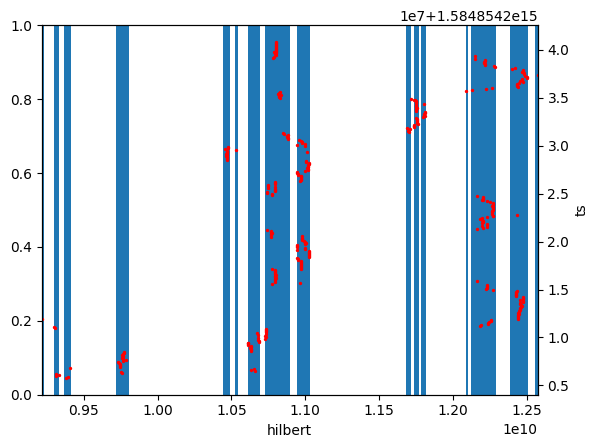

1584854250998459


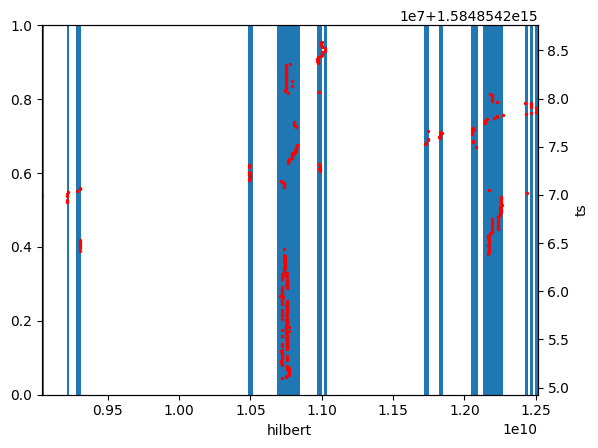

1584854296079160


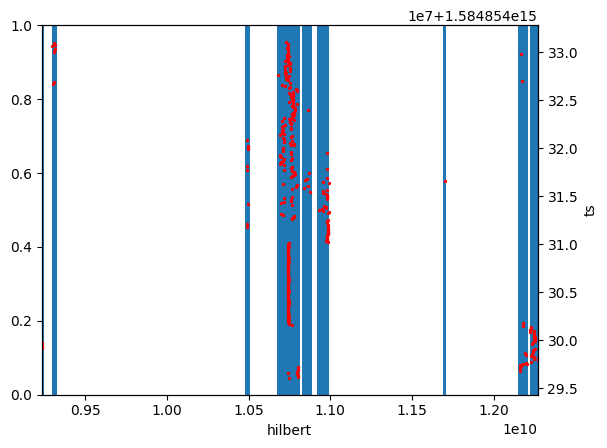

1584854341250085


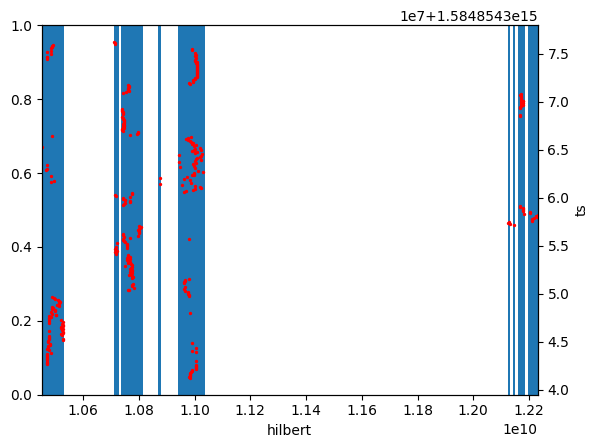

1584854386430437


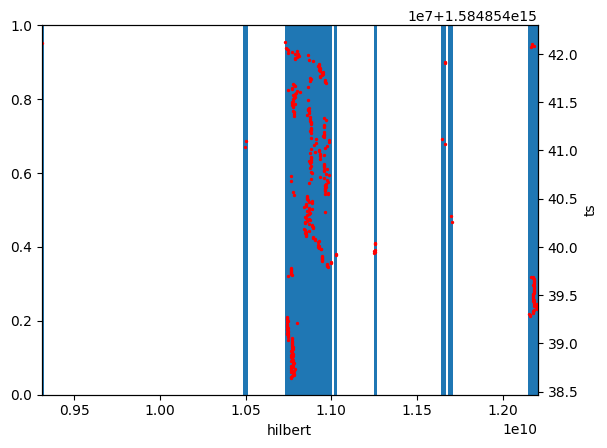

1584854431451191


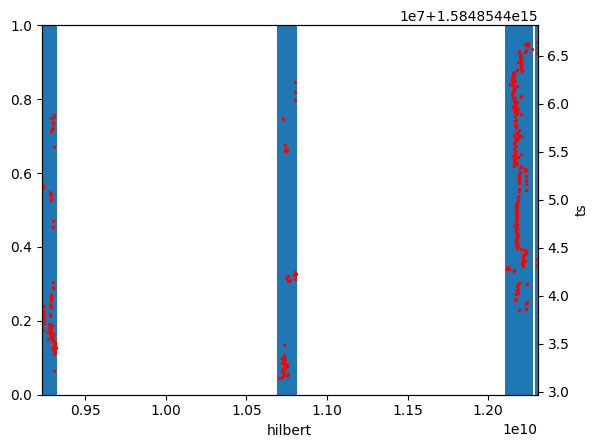

1584854476652196


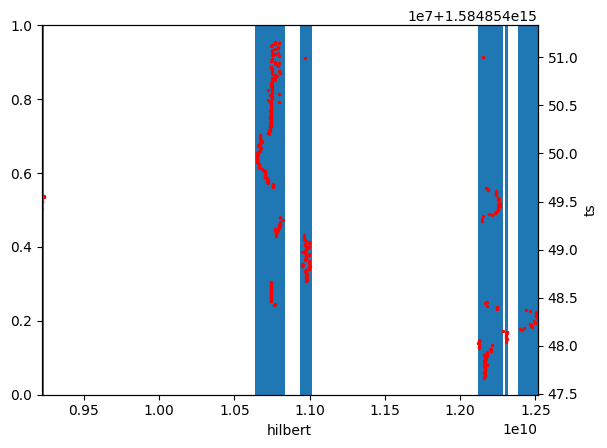

1584854521813263


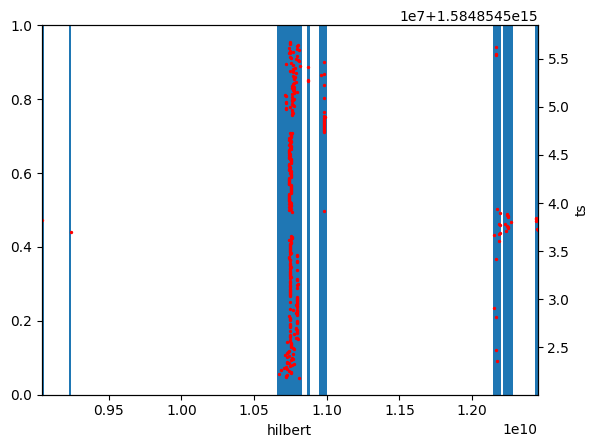

1584854566953642


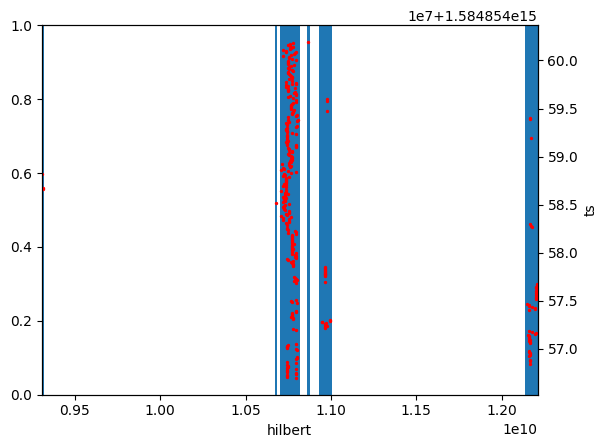

1584854612144557


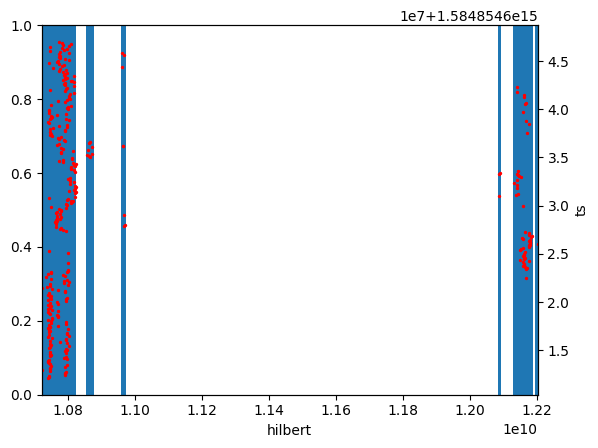

1584854657185083


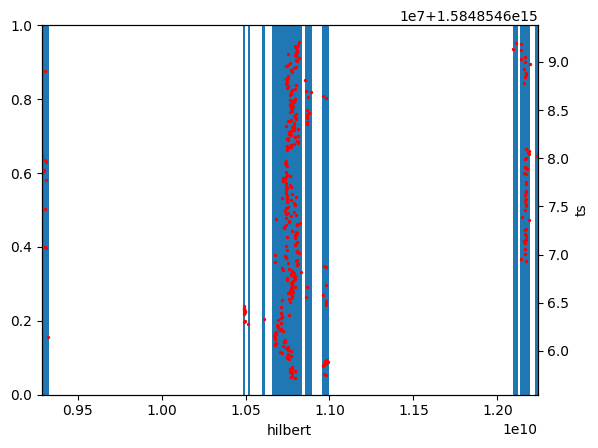

1584854702305799


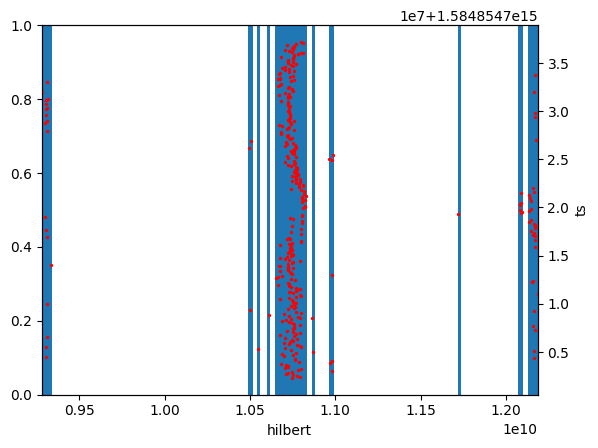

1584854747406566


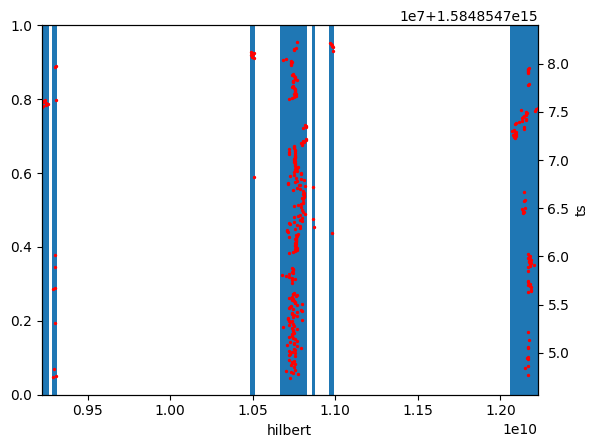

1584854792487255


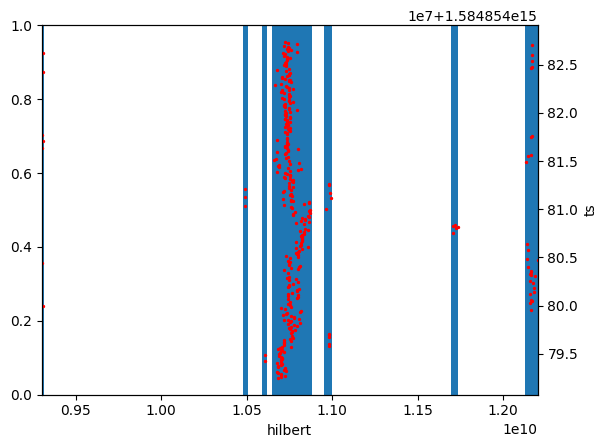

1584854837598240


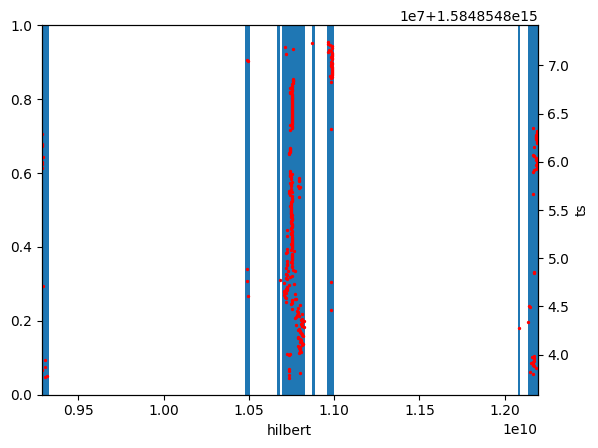

1584854882638552


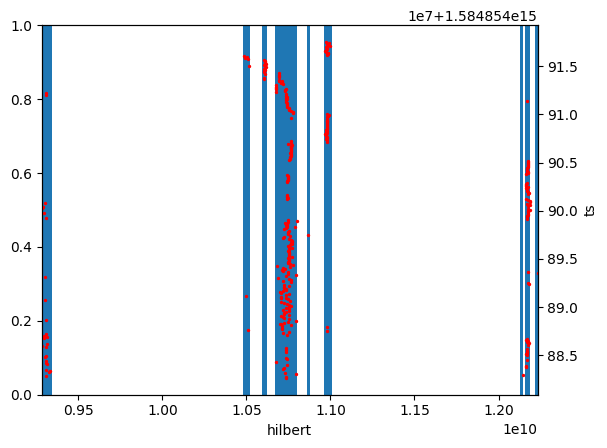

1584854927789499


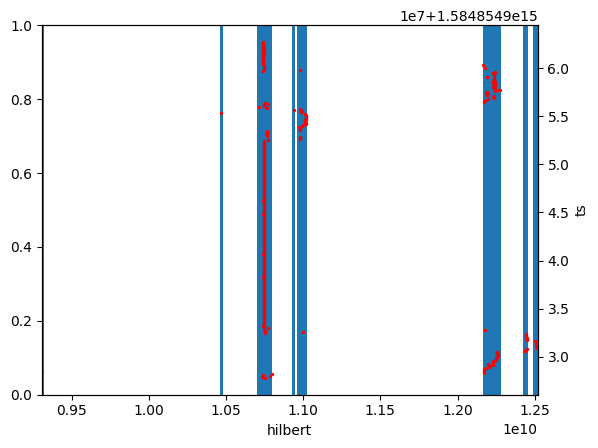

1584854973020320


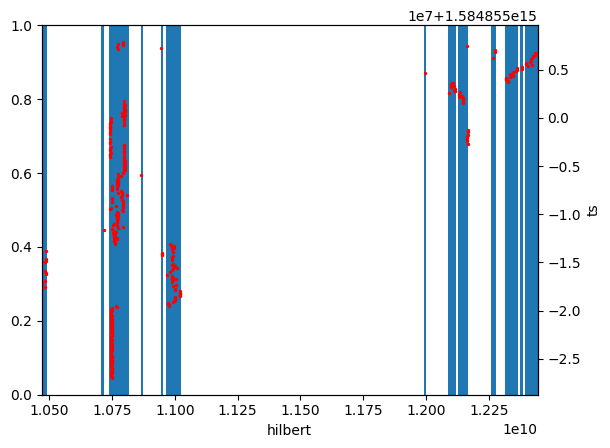

1584855018161027


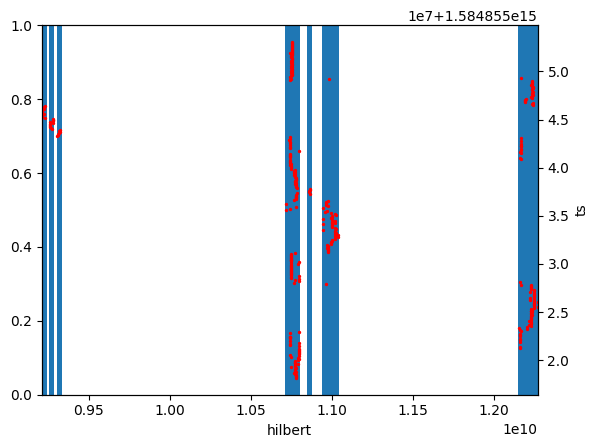

1584855063331502


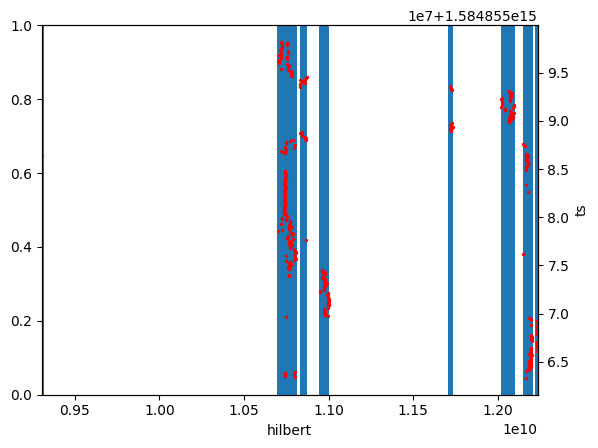

1584855108472525


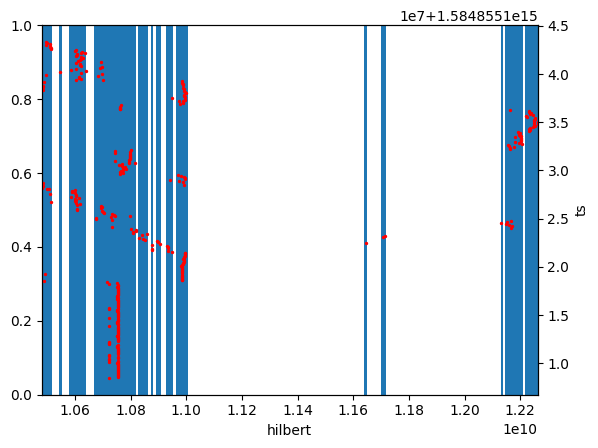

1584855153653650


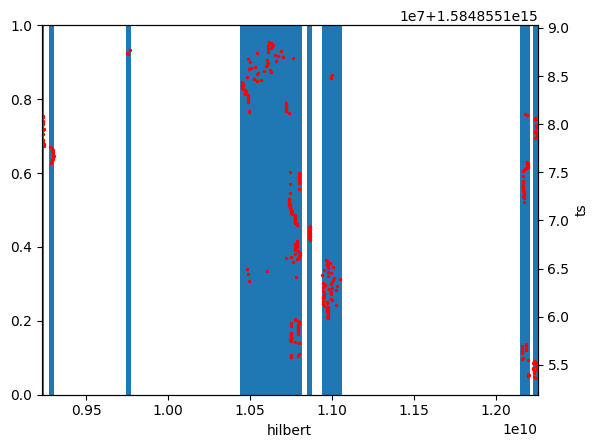

1584855198744525


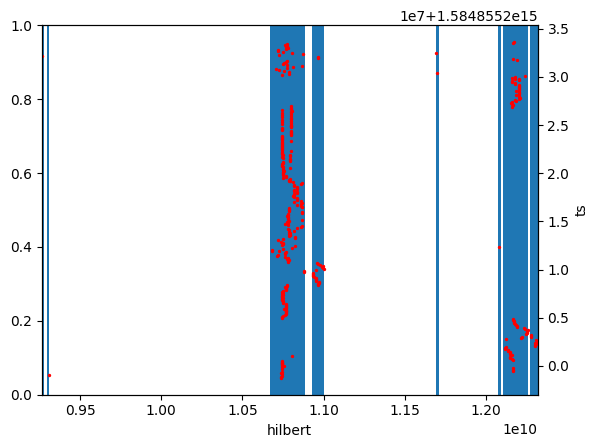

1584855243924932


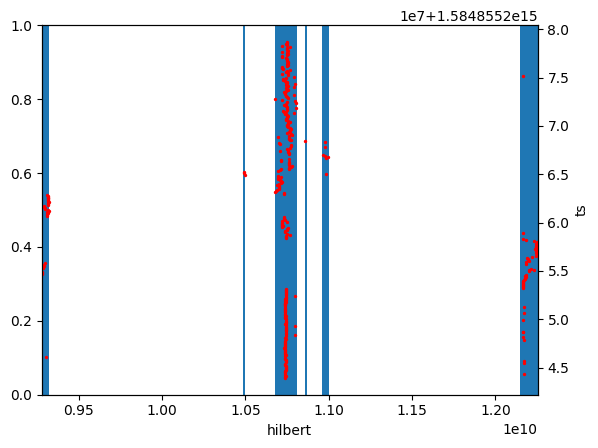

1584855288945305


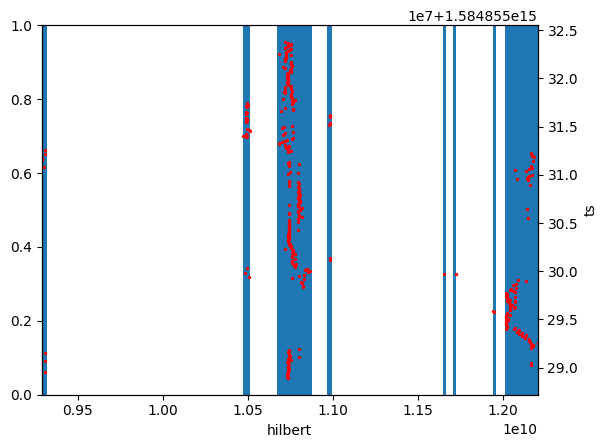

1584855334046375


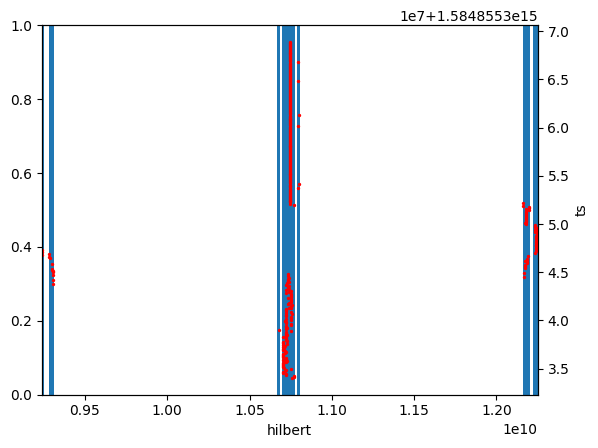

1584855379146895


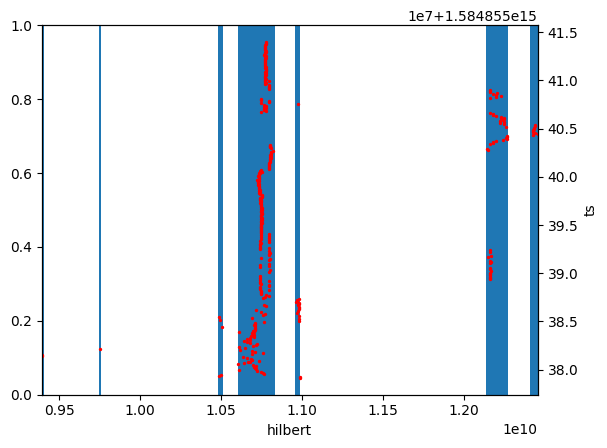

1584855424257740


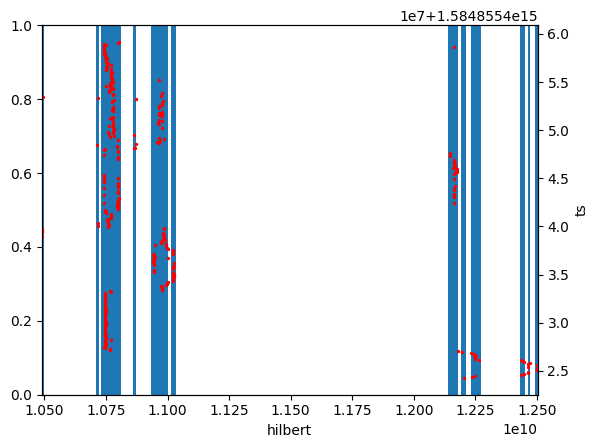

1584855469498706


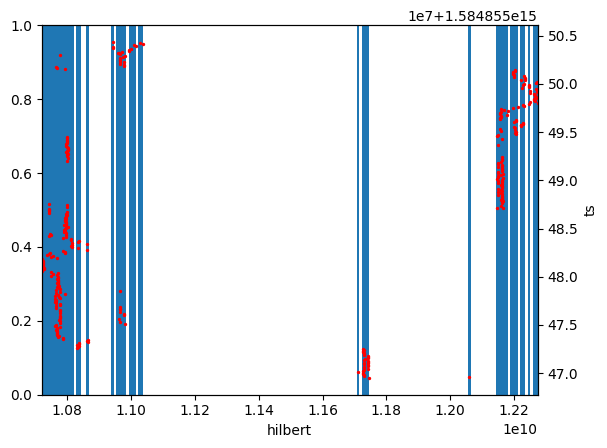

1584855469498706 is in range 3: (1584855456558058, 1584855474498497)
1584855514639465


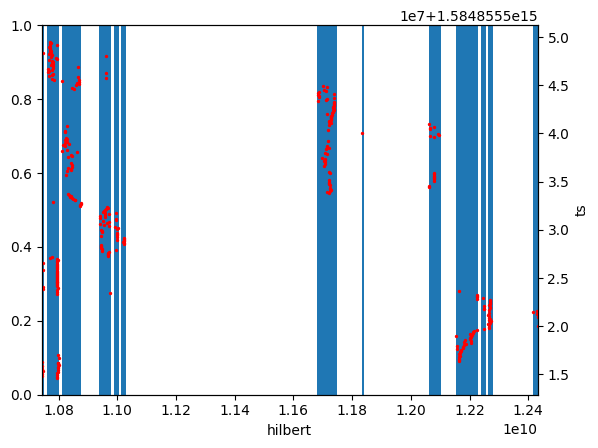

1584855559810239


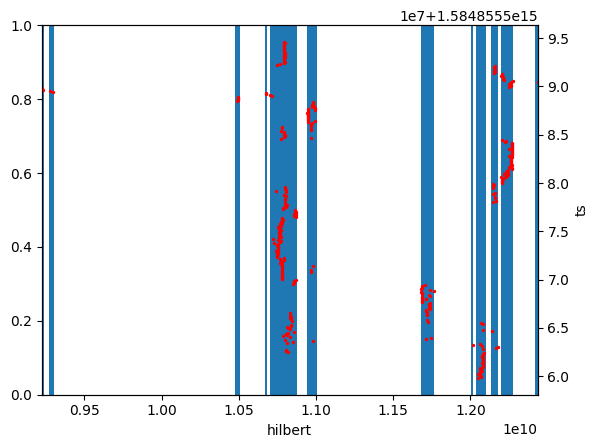

1584855559810239 is in range 2: (1584855550099753, 1584855572010558)
1584855604900842


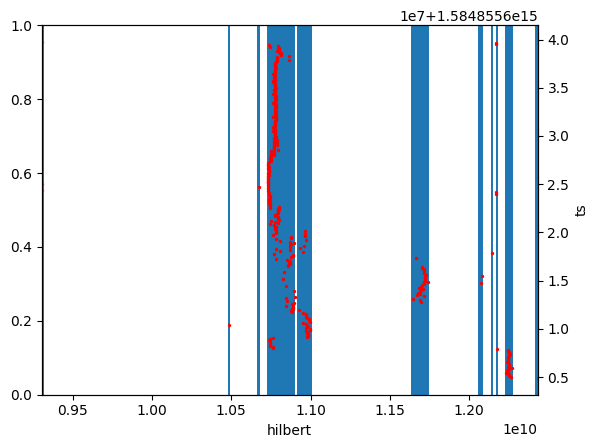

1584855649991560


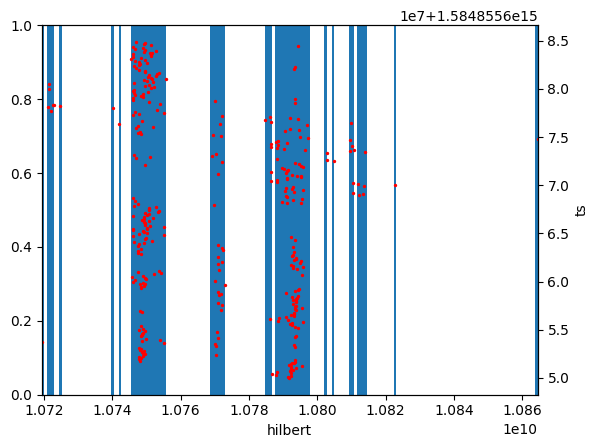

1584855695142319


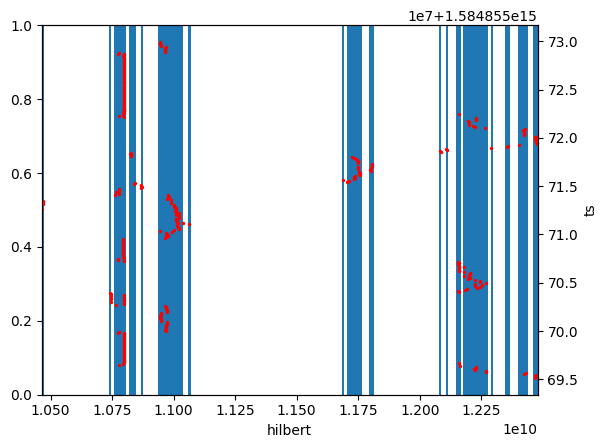

1584855740213423


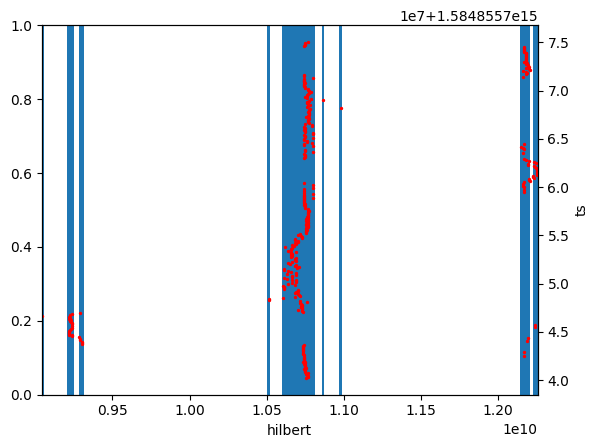

1584855785354064


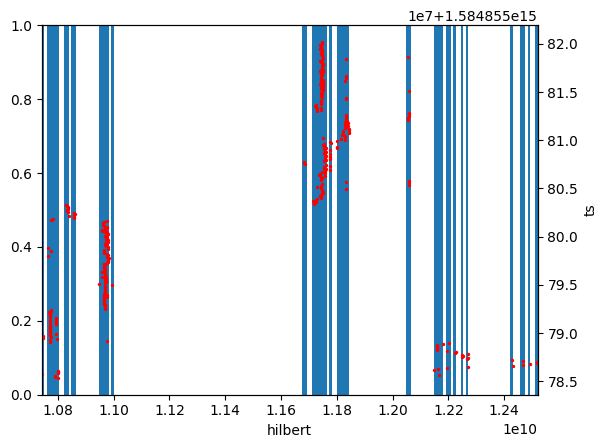

1584855830465022


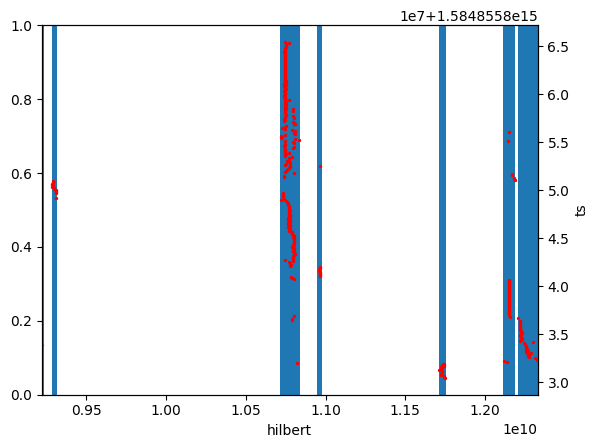

1584855830465022 is in range 1: (1584855801534728, 1584855834264867)
1584855875715844


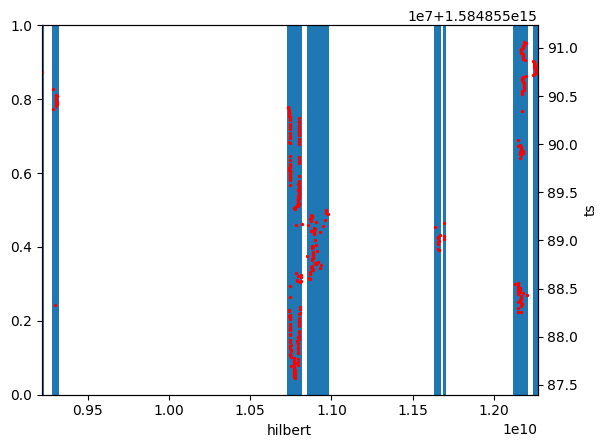

1584855920866778


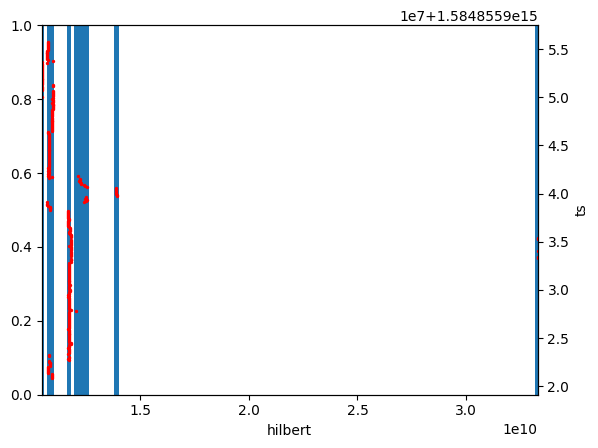

1584855920866778 is in range 0: (1584855907826492, 1584855957057419)
1584855966017615


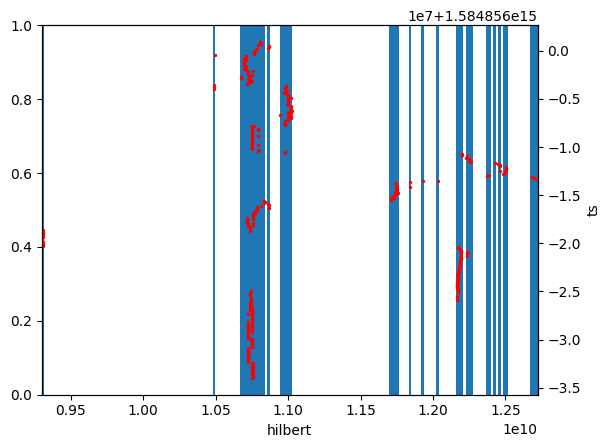

1584856011197903


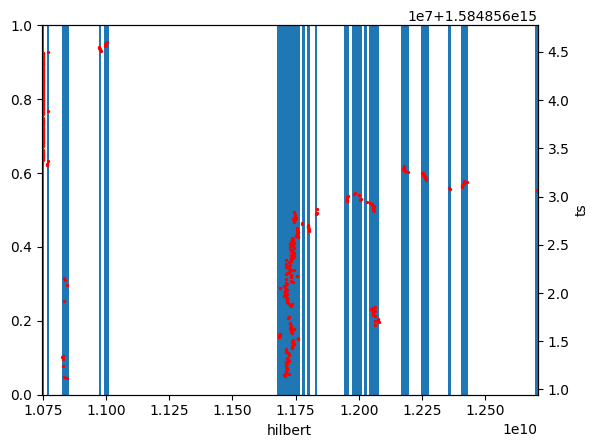

1584856056318970


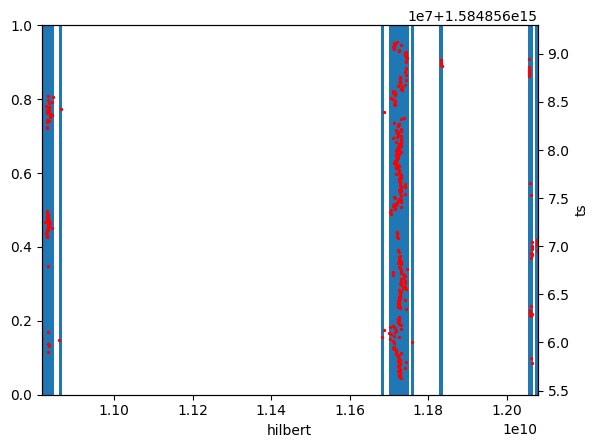

1584856101489818


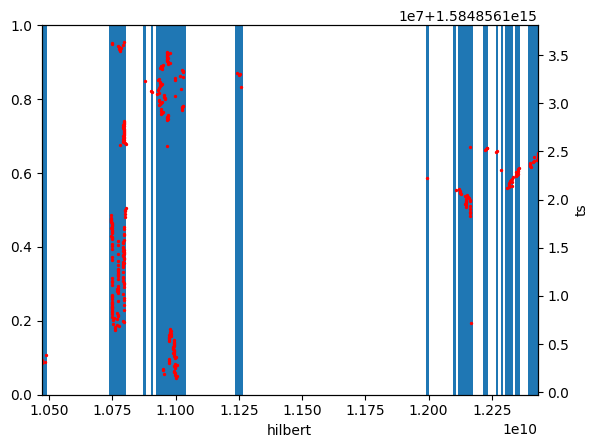

1584856146660421


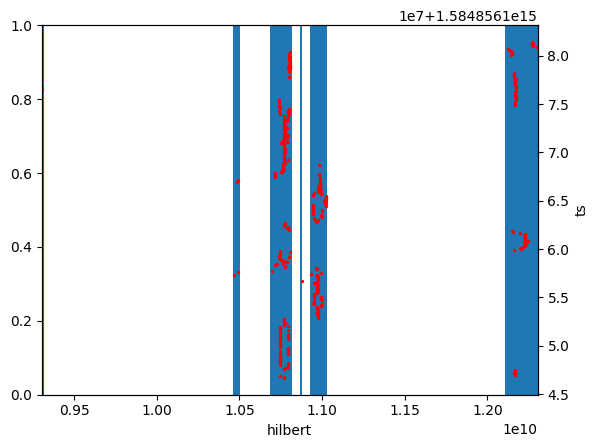

1584856191701431


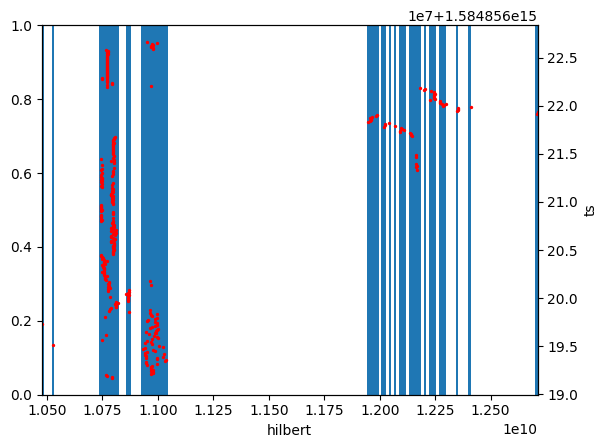

1584856236872030


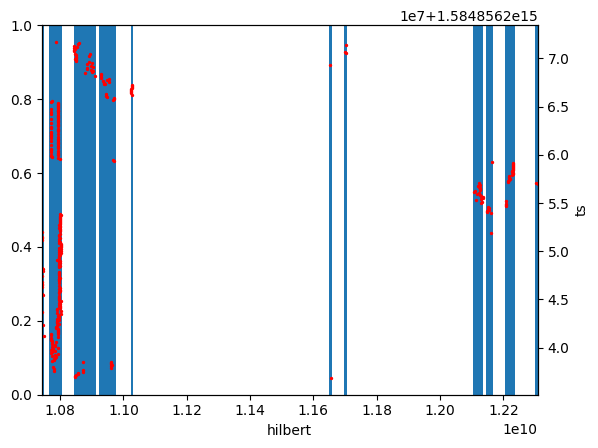

1584856281913012


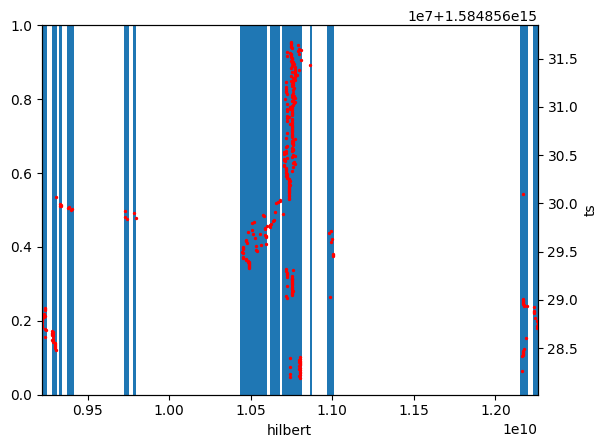

1584856327033887


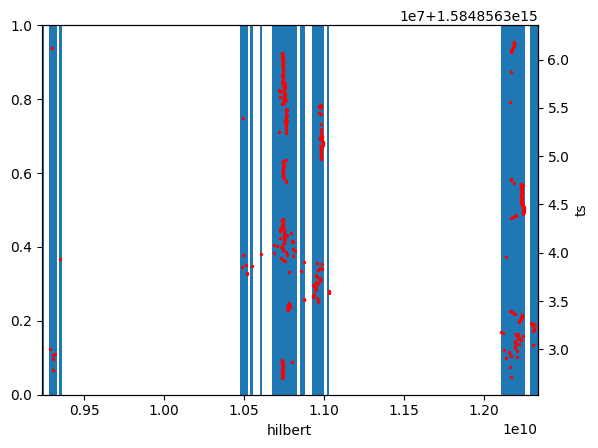

1584856372134647


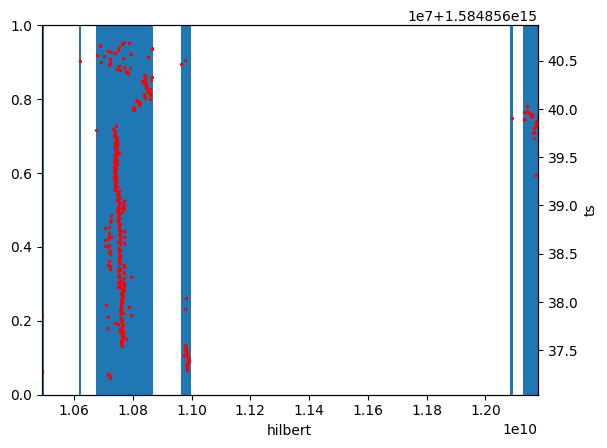

1584856417175187


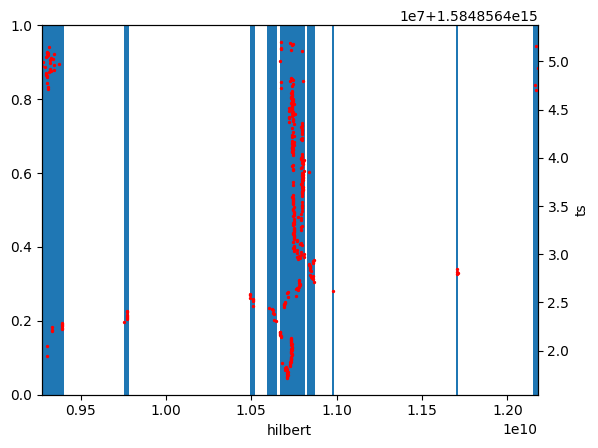

1584856462306255


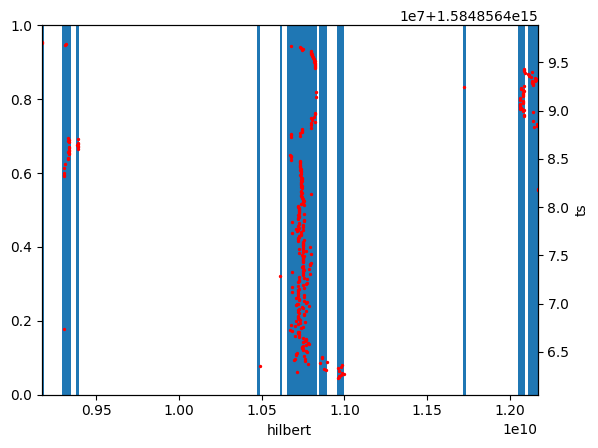

75


In [105]:
i = 0
roundabout_counter = 0
time_checker = 0

while i < (acc_data_size - chunk_size) :
    
    sub_ra = acc_data.iloc[i:i+chunk_size, :]
    sub_hilbert = average_calculator(sub_ra, 'hilbert', 5)
    correlation = correlation_calculator(sub_hilbert, ref_hilbert, 3)  
    
    if (correlation > 0.8) and index_store == (i-1):  # the pattern match the ref roundabout pattern
        
        time_checker += 1   
        index_store = i
       
        if time_checker > 100:
            roundabout_counter += 1
            print( acc_data['ts'][i])
            plot_sfc_2d(sub_ra, 'hilbert')
            time_checker = 0
            ra_range_detector(acc_data['ts'][i]) 
            i += chunk_size
        else: 
            i += 1 

    else :  # the pattern is not a match
        index_store = i
        i += 1
        time_checker = 0
        
print(roundabout_counter)

### Normalized df:

#### Morton

In [26]:
i = 0
roundabout_counter = 0
time_checker = 0
index_store = 0

while i < (acc_data_size - chunk_size) :
    
    sub_ra = acc_data_normalized.iloc[i:i+chunk_size, :]
    sub_morton = average_calculator(sub_ra, 'morton', 5)
    correlation = correlation_calculator(sub_morton, ref_norm_morton, 3)  
    
    if (correlation > 0.66) and index_store == (i-1):  # the pattern match the ref roundabout pattern
        
        time_checker += 1   
        index_store = i
       
        if time_checker > 100:
            roundabout_counter += 1
            print( acc_data['ts'][i])
#             plot_sfc_2d(sub_ra, 'morton')
            time_checker = 0
            ra_range_detector(acc_data['ts'][i]) 
            i += chunk_size
        else: 
            i += 1 

    else :  # the pattern is not a match
        index_store = i
        i += 1
        time_checker = 0

print(roundabout_counter)

1584853124243997
1584853169214574
1584853214245023
1584853259305227
1584853304386006
1584853349356451
1584853394416863
1584853439407326
1584853484508041
1584853484508041 is in range 4: (1584853465258107, 1584853495138141)
1584853529548678
1584853574599391
1584853619569495
1584853664700468
1584853709870718
1584853754901771
1584853800142437
1584853845182859
1584853845182859 is in range 5: (1584853829083708, 1584853864063504)
1584853890273398
1584853935313781
1584853980334747
1584854025435327
1584854070615660
1584854115716638
1584854160747117
1584854205787880
1584854250998459
1584854296079160
1584854341250085
1584854386430437
1584854431451191
1584854476652196
1584854521813263
1584854566953642
1584854612144557
1584854657185083
1584854702305799
1584854747406566
1584854792487255
1584854837598240
1584854882638552
1584854927789499
1584854973020320
1584855018161027
1584855063331502
1584855108472525
1584855153653650
1584855198744525
1584855243924932
1584855288945305
1584855334046375
158485537914

#### Hilbert

1584853124243997


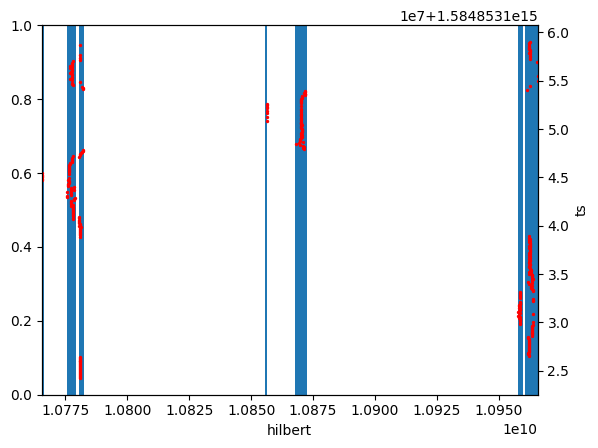

1584853169214574


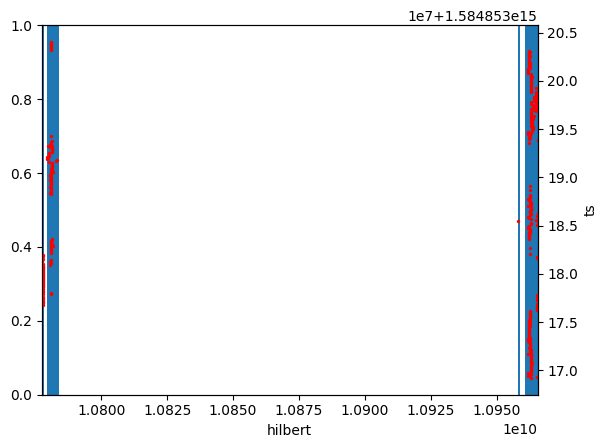

1584853214245023


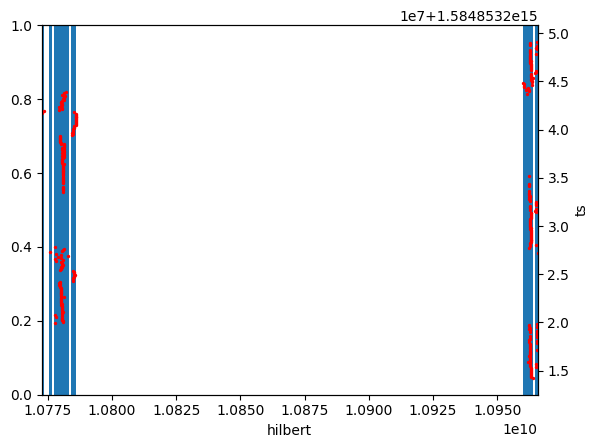

1584853259305227


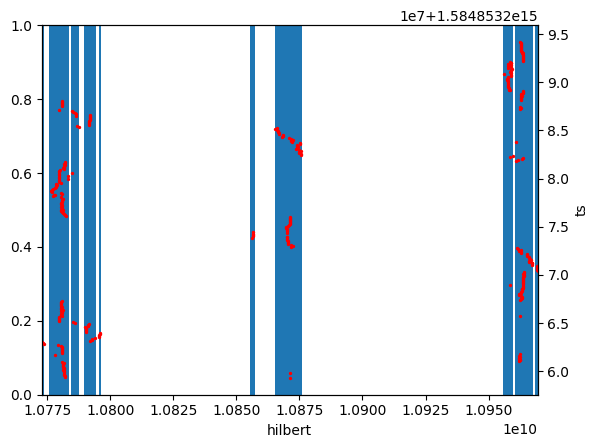

1584853304386006


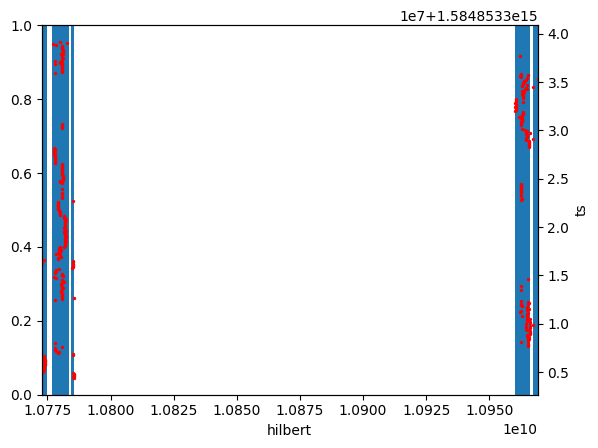

1584853349356451


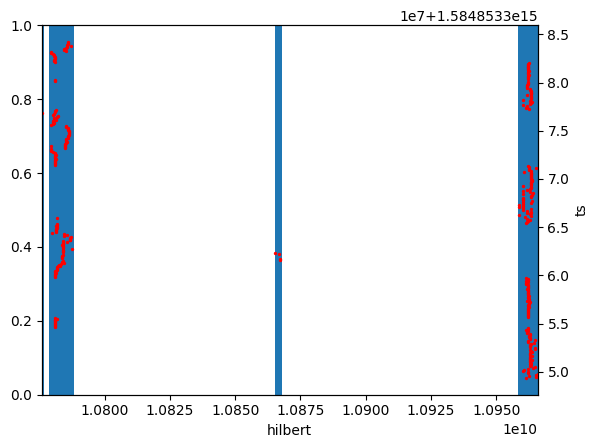

1584853394416863


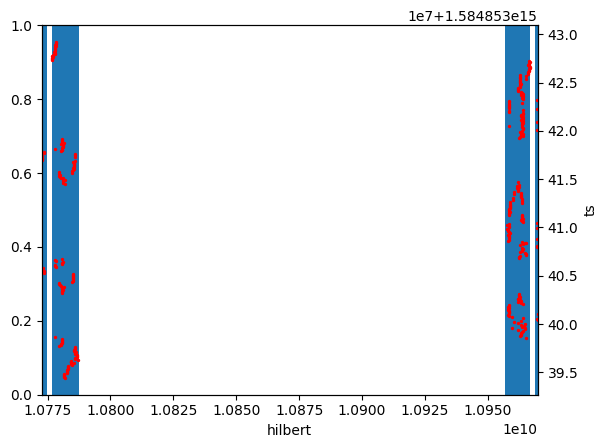

1584853439407326


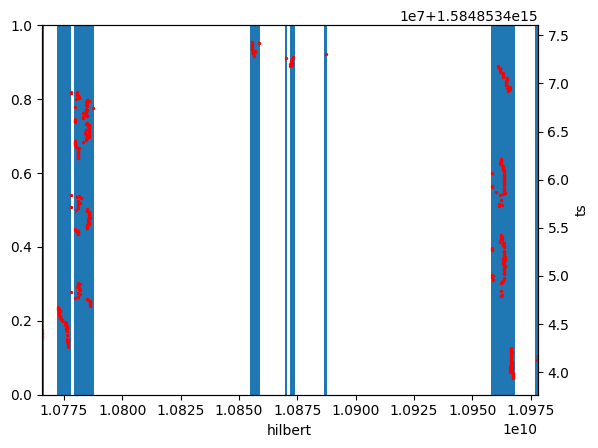

1584853484508041


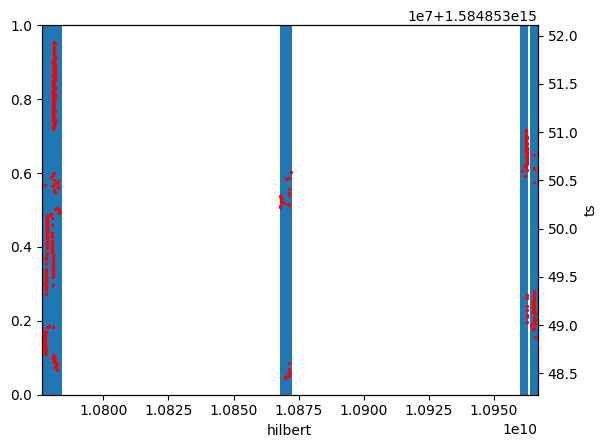

1584853484508041 is in range 4: (1584853465258107, 1584853495138141)
1584853529548678


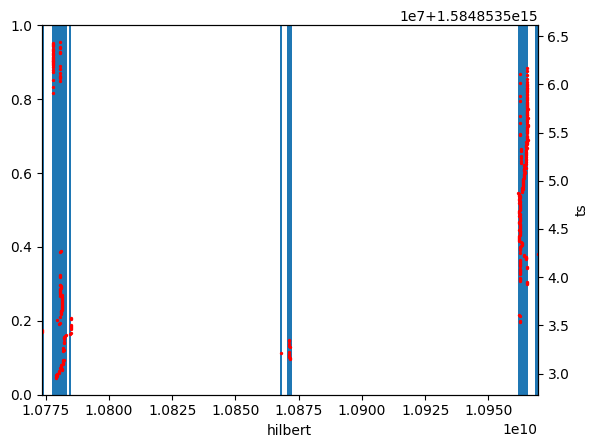

1584853574599391


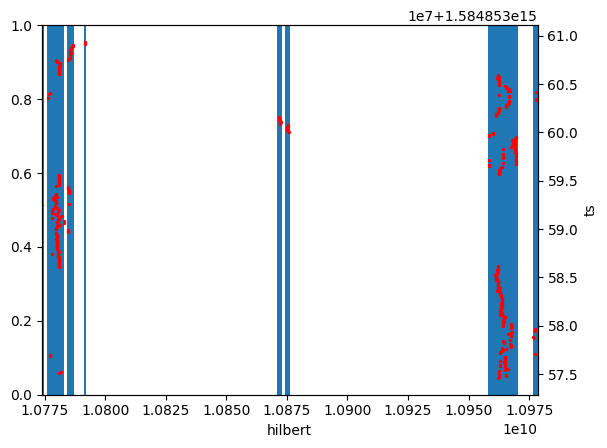

1584853619569495


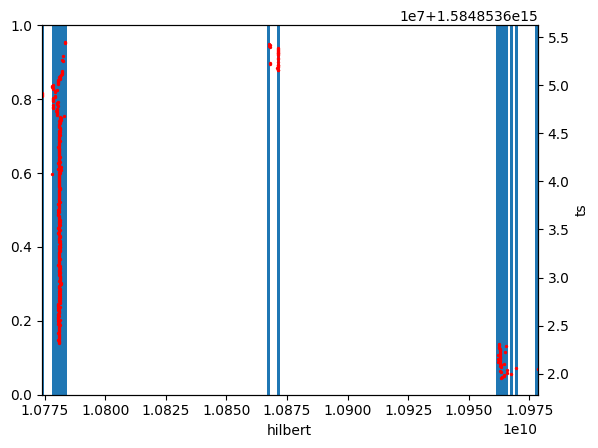

1584853664700468


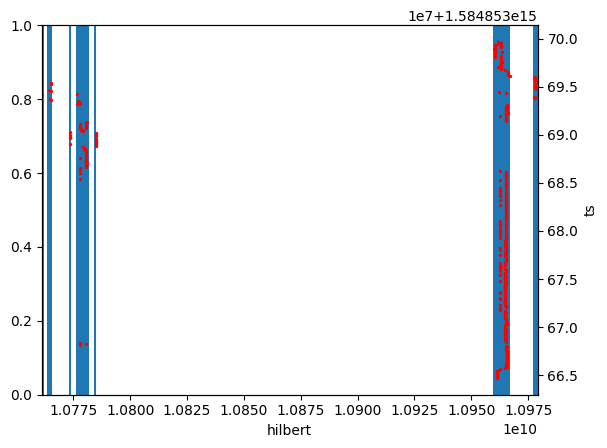

1584853709870718


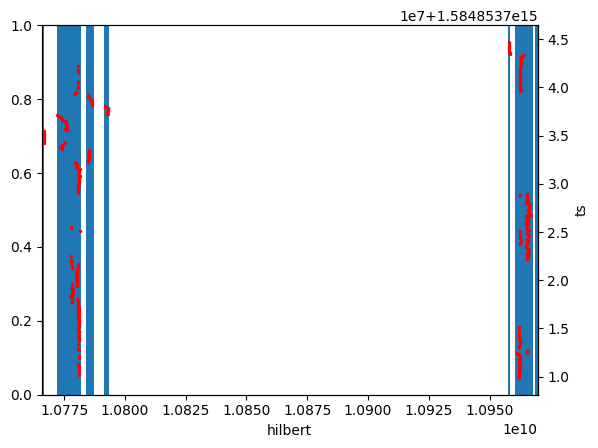

1584853754901771


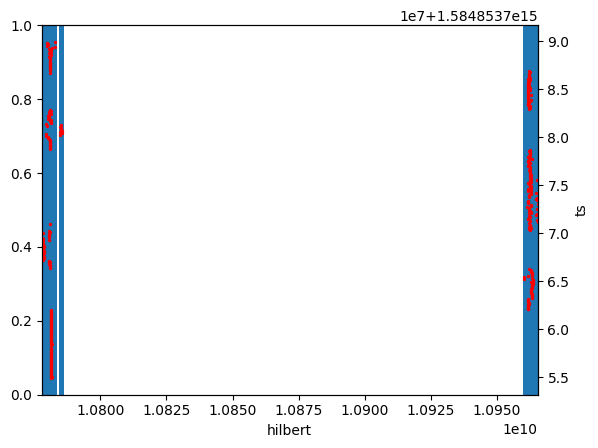

1584853800142437


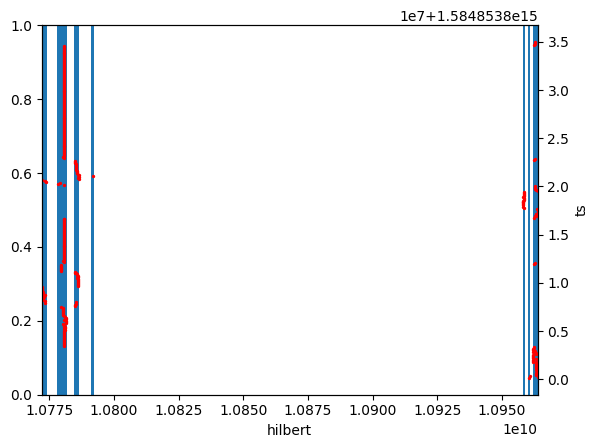

1584853845182859


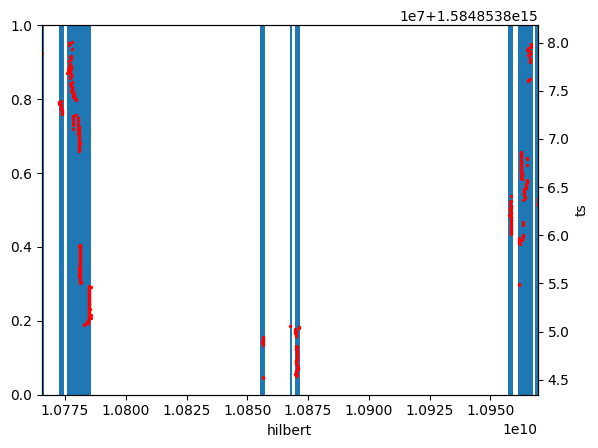

1584853845182859 is in range 5: (1584853829083708, 1584853864063504)
1584853890273398


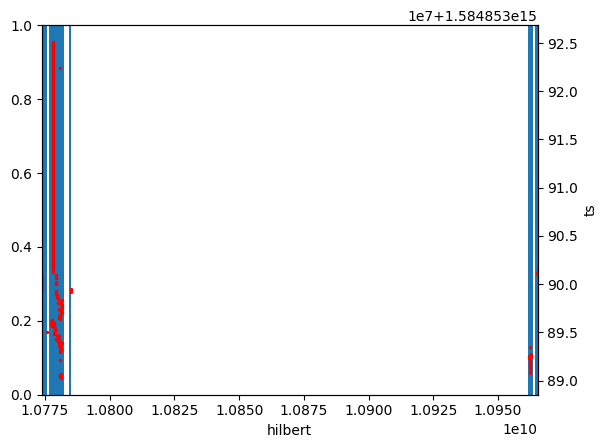

1584853935313781


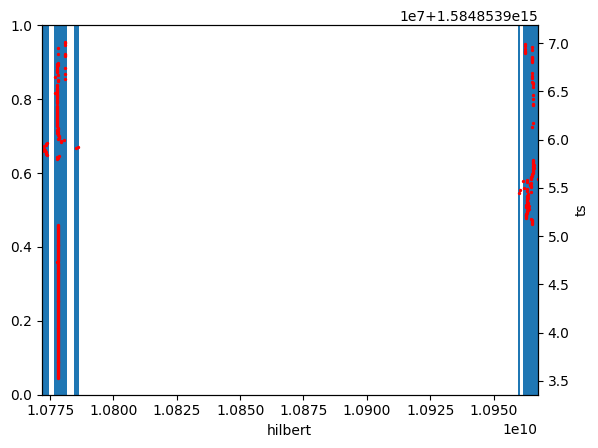

1584853980334747


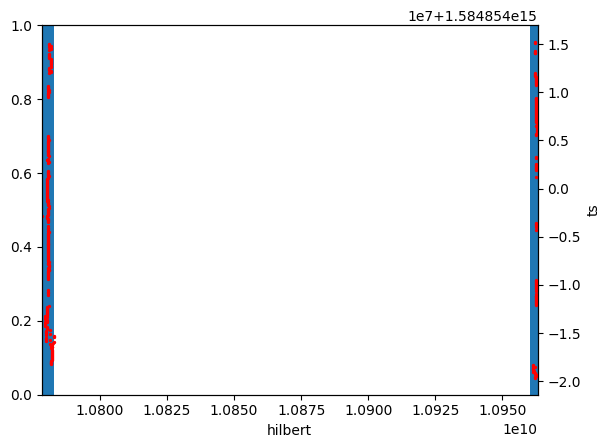

1584854025435327


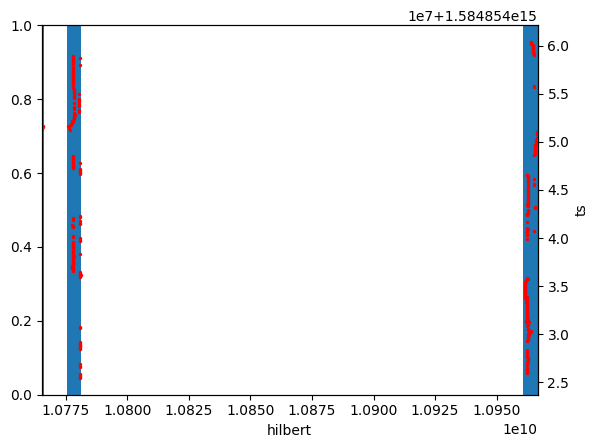

1584854070615660


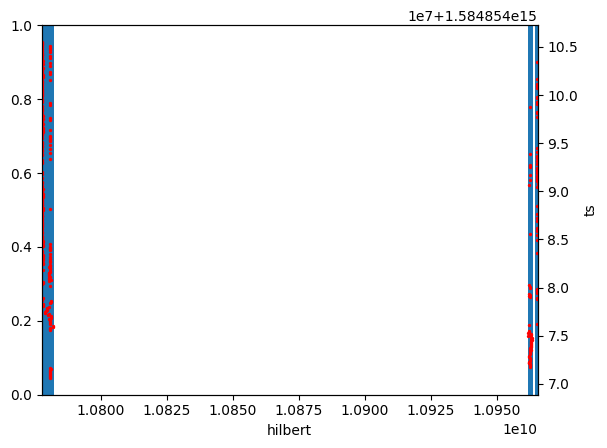

1584854115716638


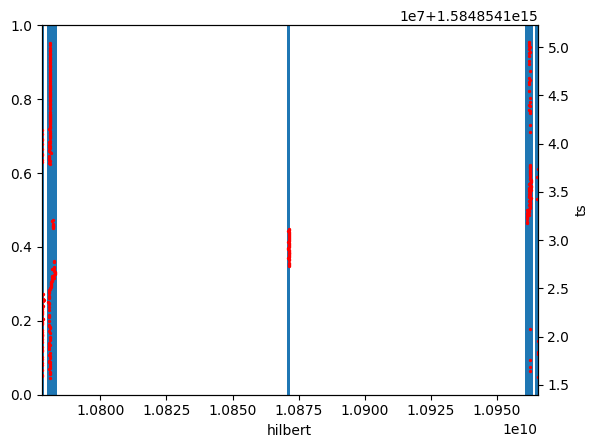

1584854160747117


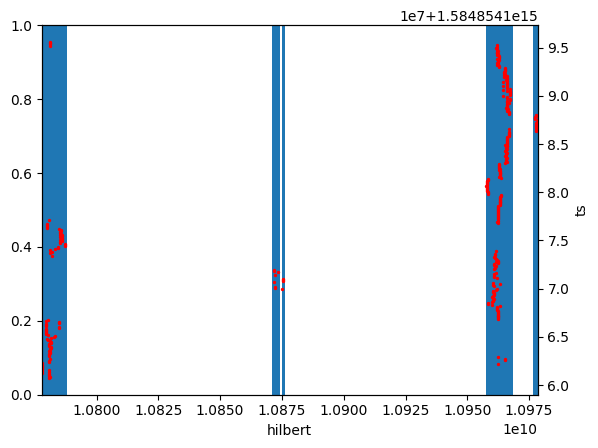

1584854205787880


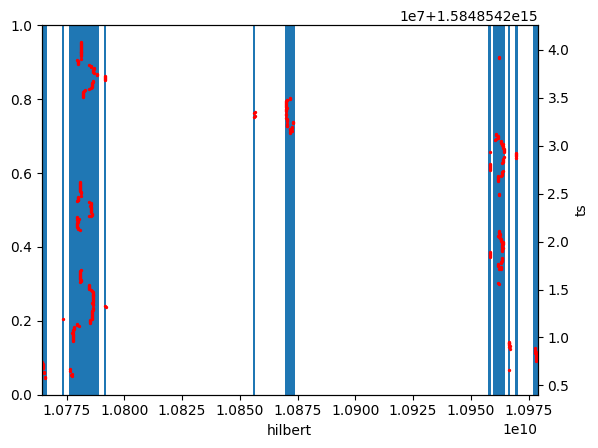

1584854250998459


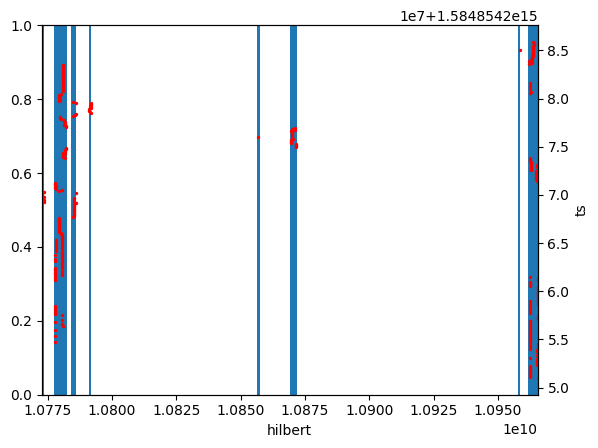

1584854296079160


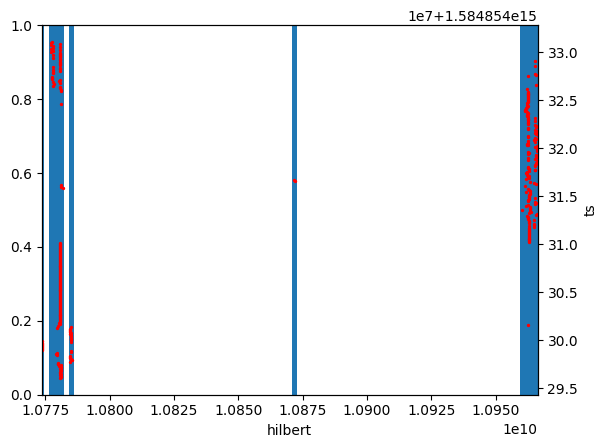

1584854341250085


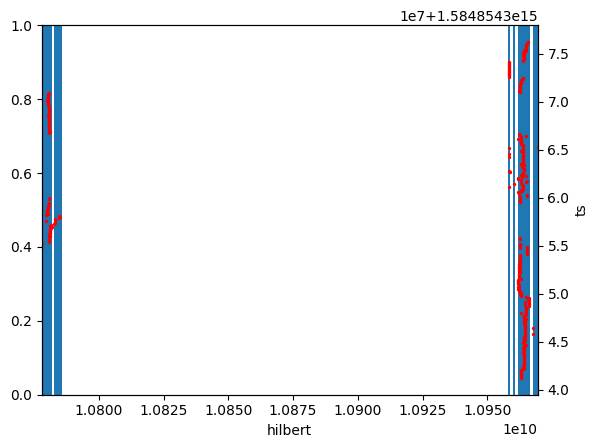

1584854386430437


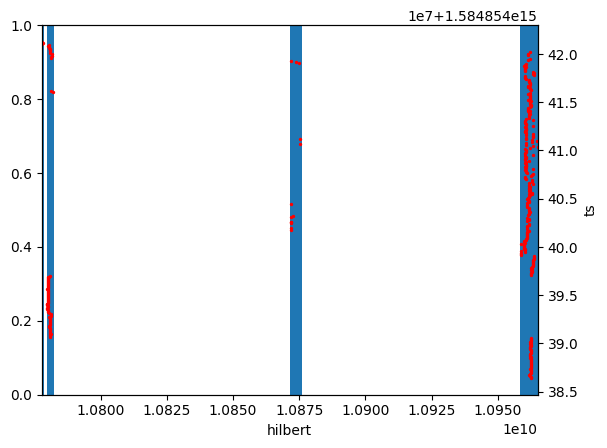

1584854431451191


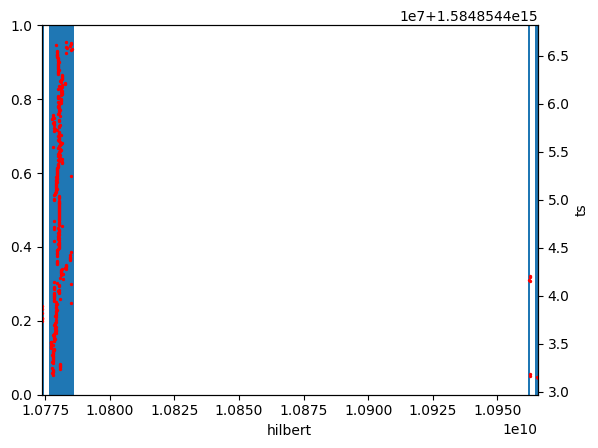

1584854476652196


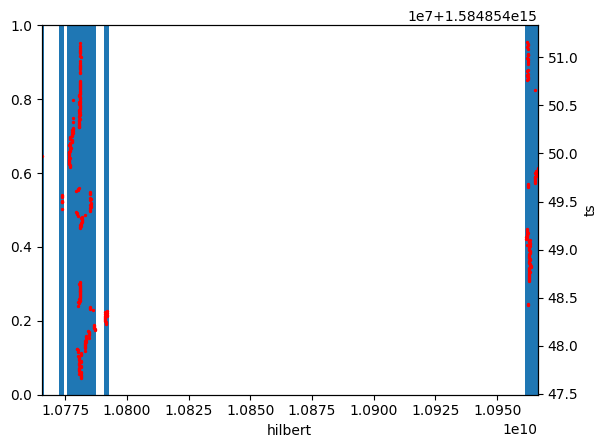

1584854521813263


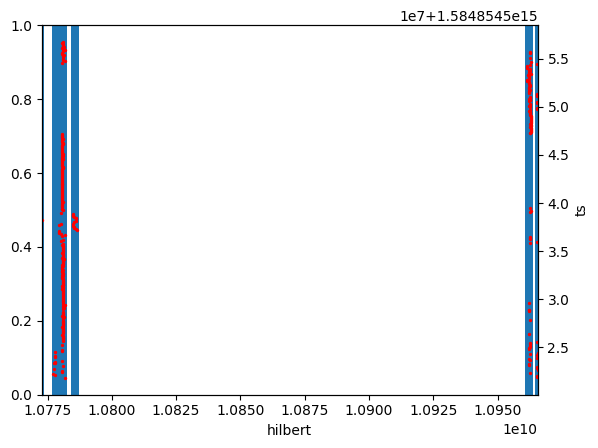

1584854566953642


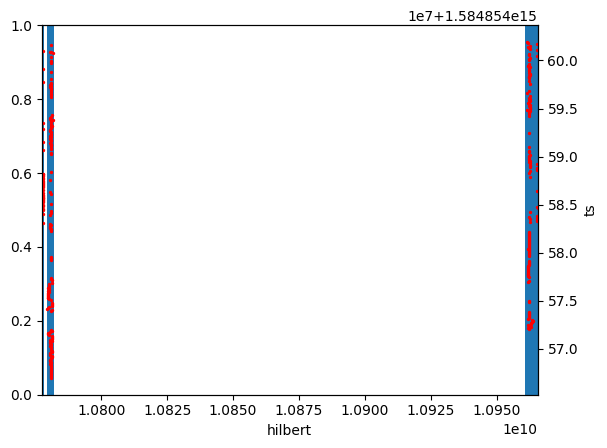

1584854612144557


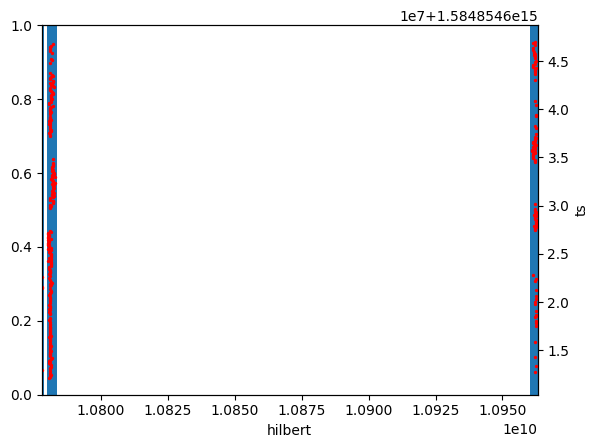

1584854657185083


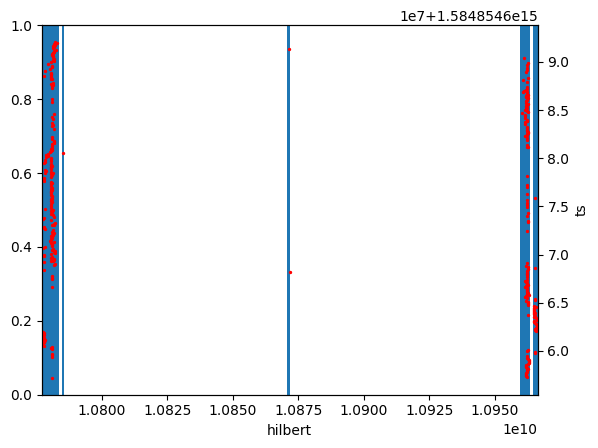

1584854702305799


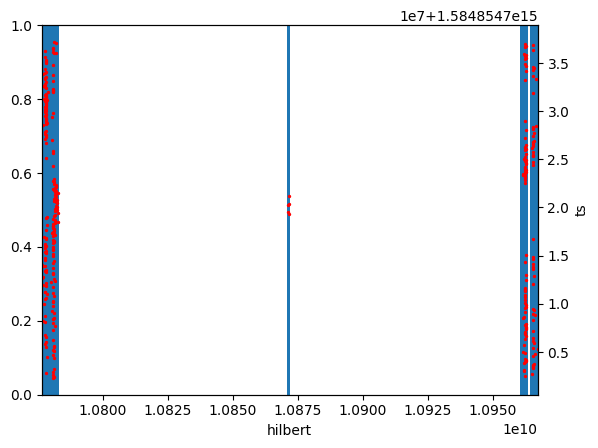

1584854747406566


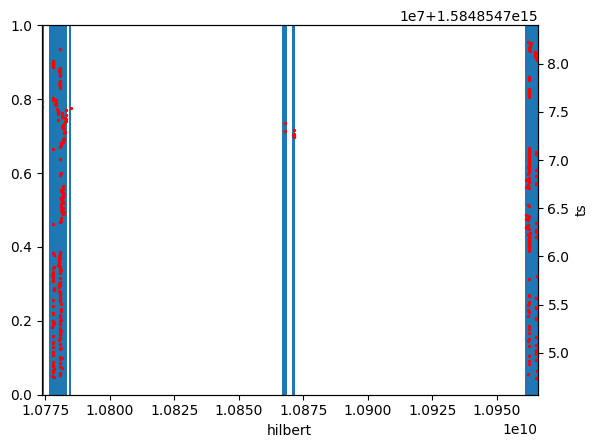

1584854792487255


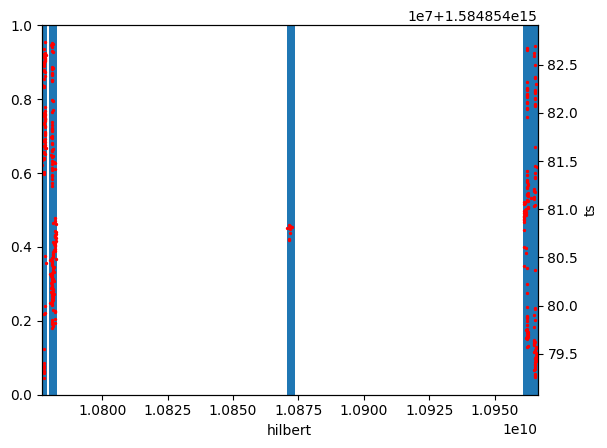

1584854837598240


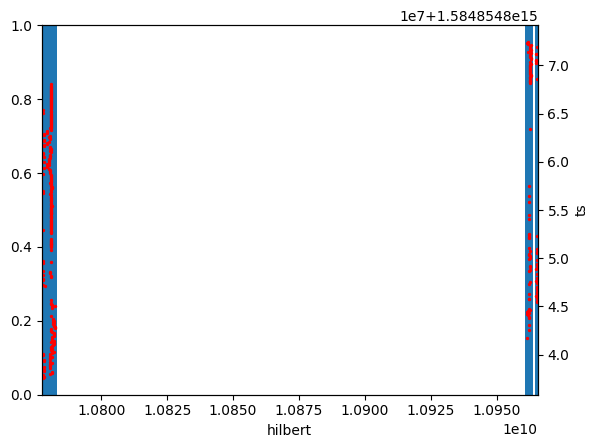

1584854882638552


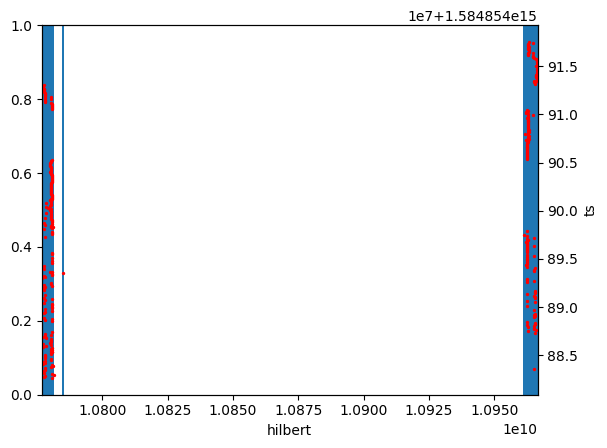

1584854927789499


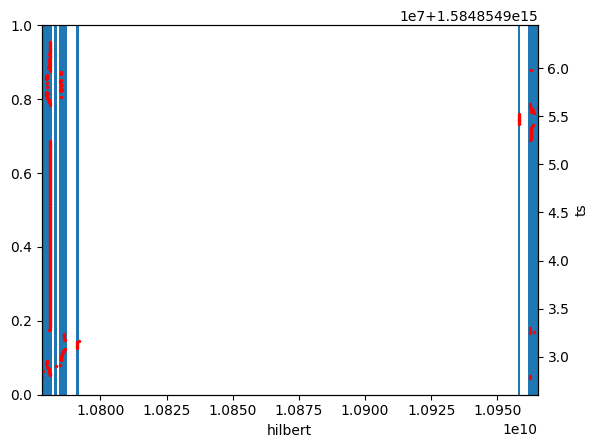

1584854973020320


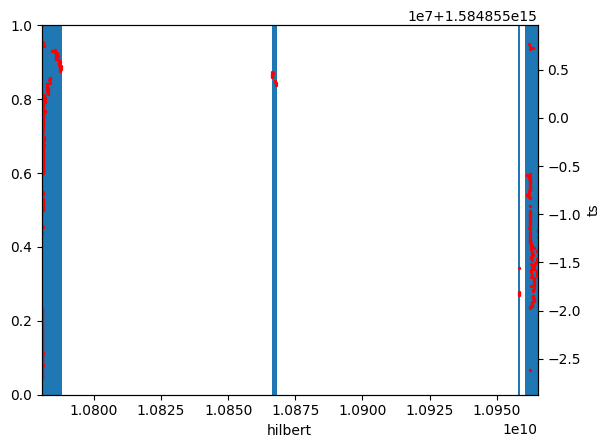

1584855018161027


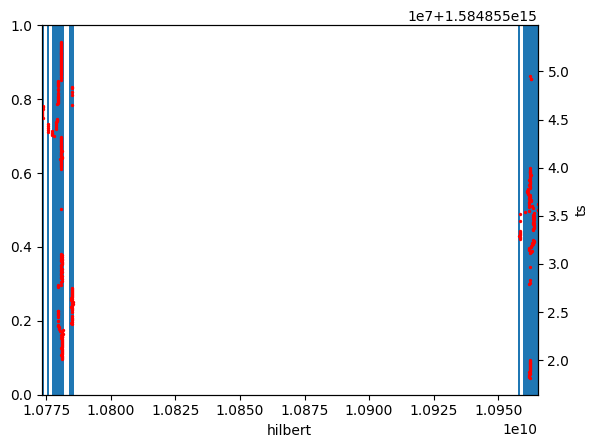

1584855063331502


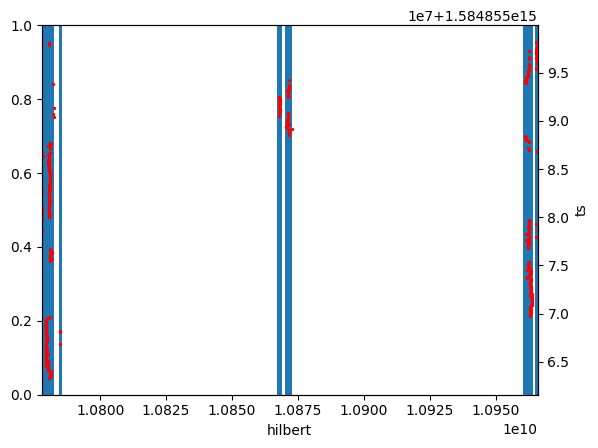

1584855108472525


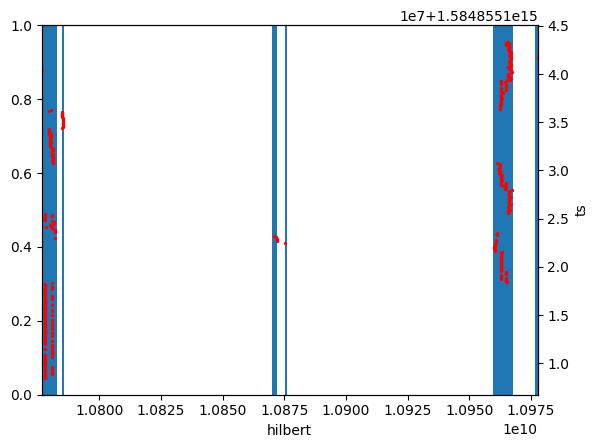

1584855153653650


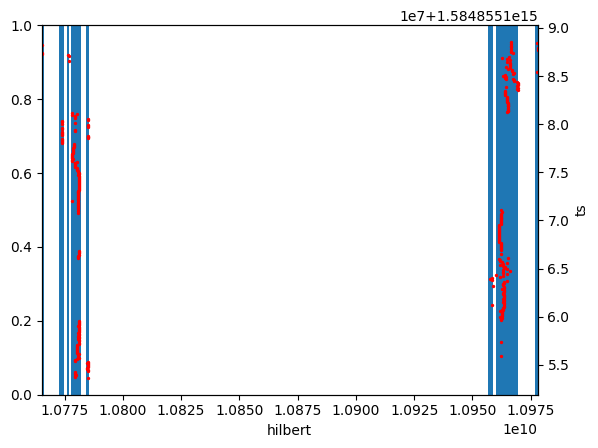

1584855198744525


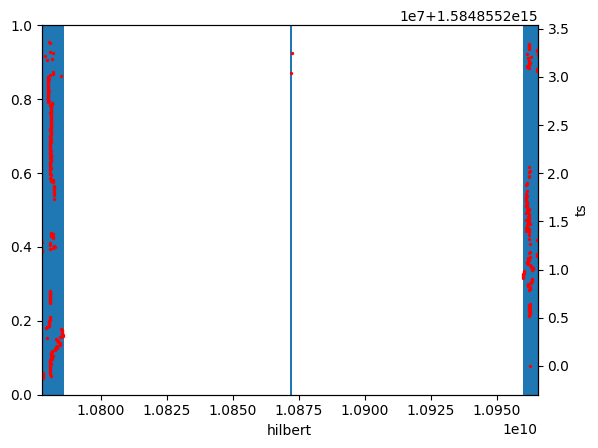

1584855243924932


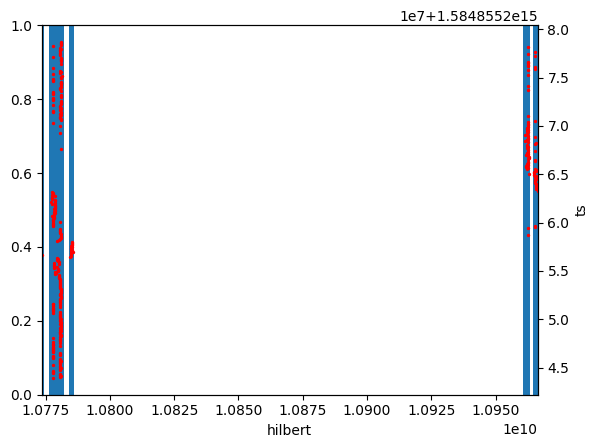

1584855288945305


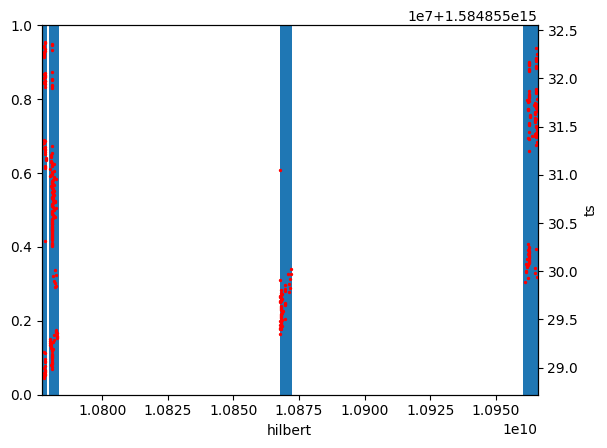

1584855334046375


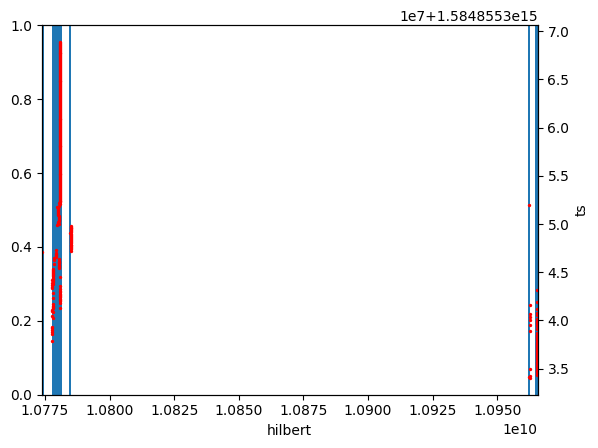

1584855379146895


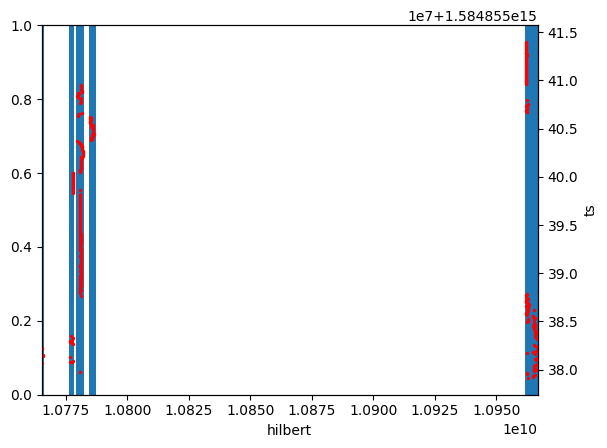

1584855424257740


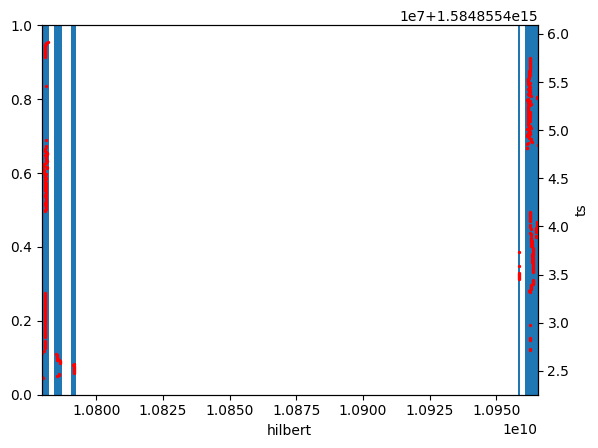

1584855469498706


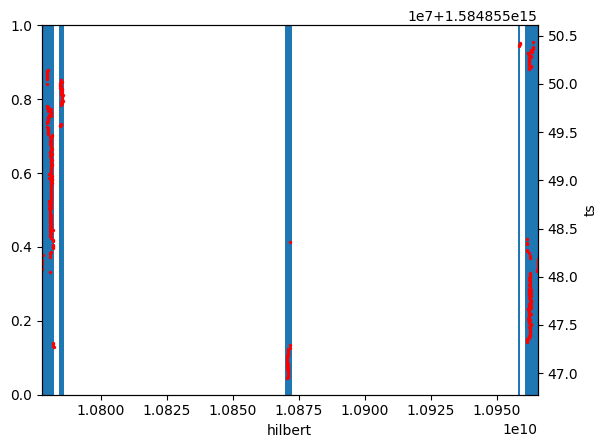

1584855469498706 is in range 3: (1584855456558058, 1584855474498497)
1584855514639465


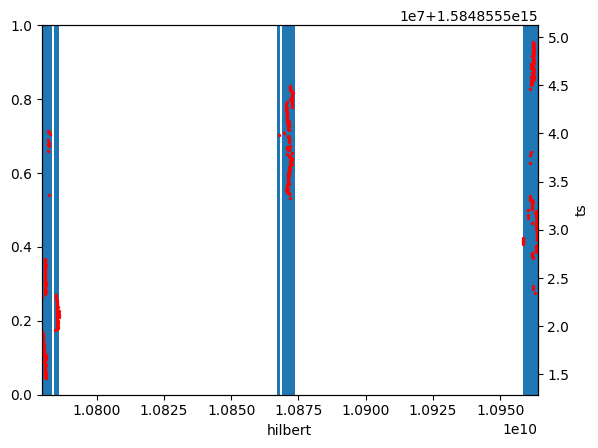

1584855559810239


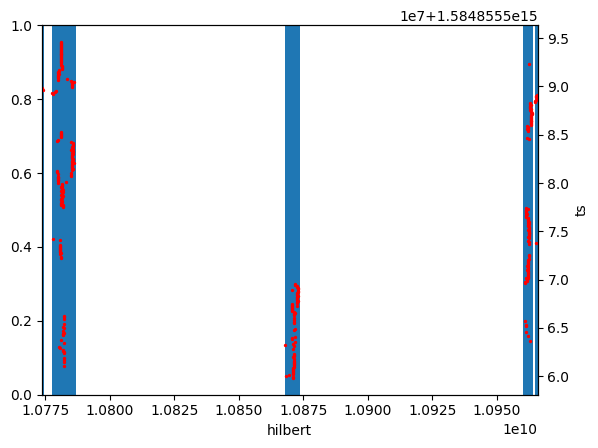

1584855559810239 is in range 2: (1584855550099753, 1584855572010558)
1584855604900842


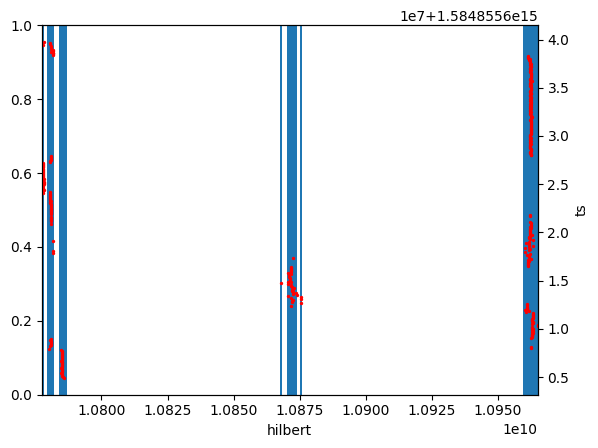

1584855649991560


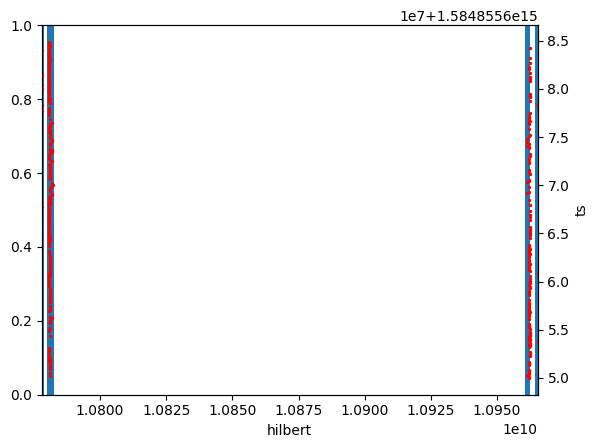

1584855695142319


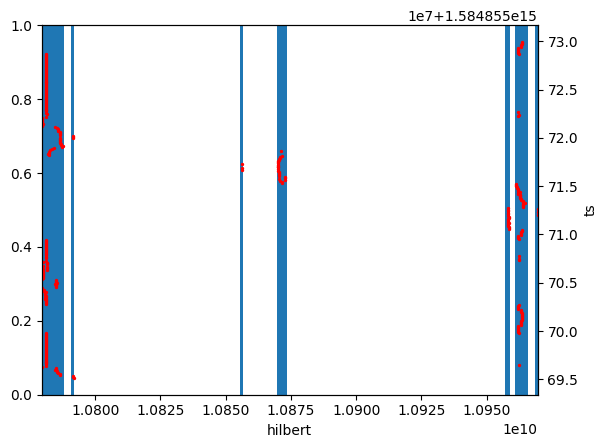

1584855740213423


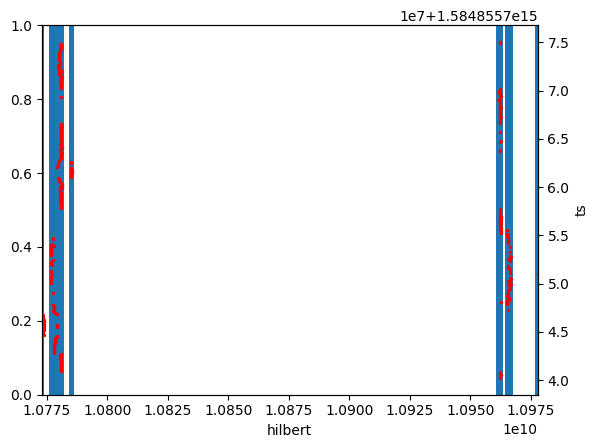

1584855785354064


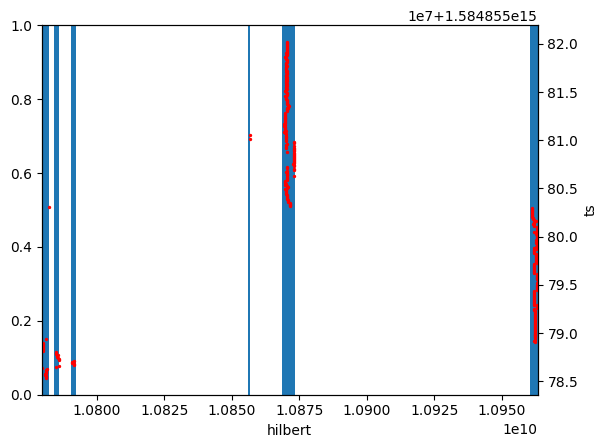

1584855830465022


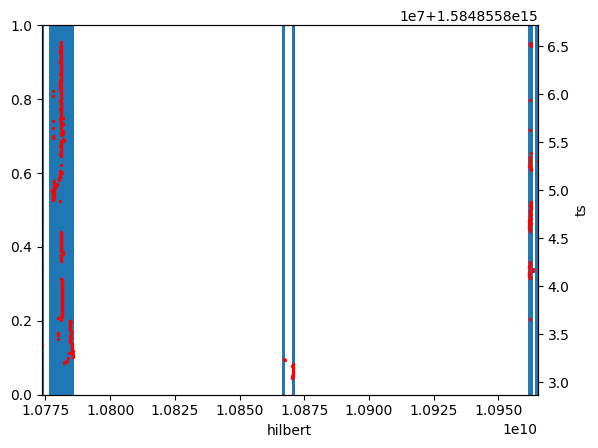

1584855830465022 is in range 1: (1584855801534728, 1584855834264867)
1584855875715844


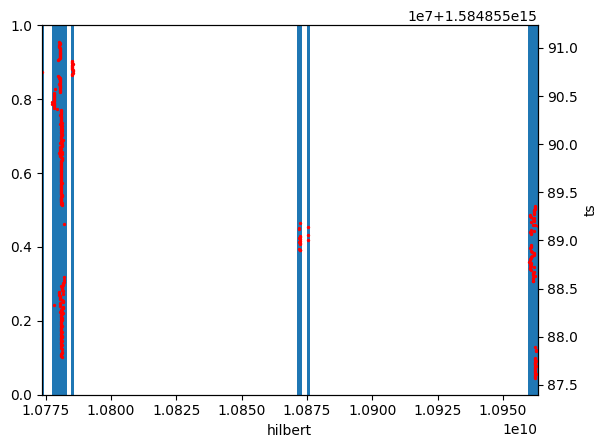

1584855920866778


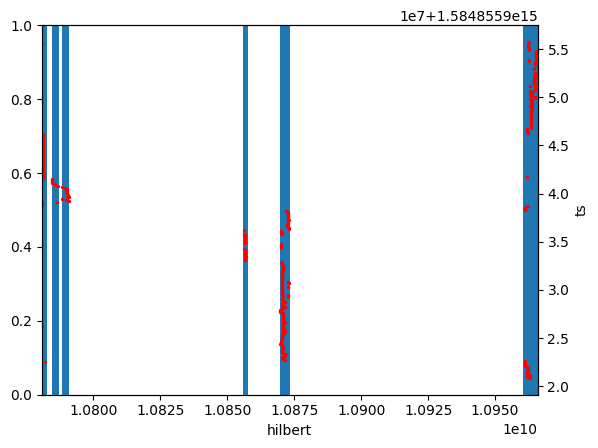

1584855920866778 is in range 0: (1584855907826492, 1584855957057419)
1584855966017615


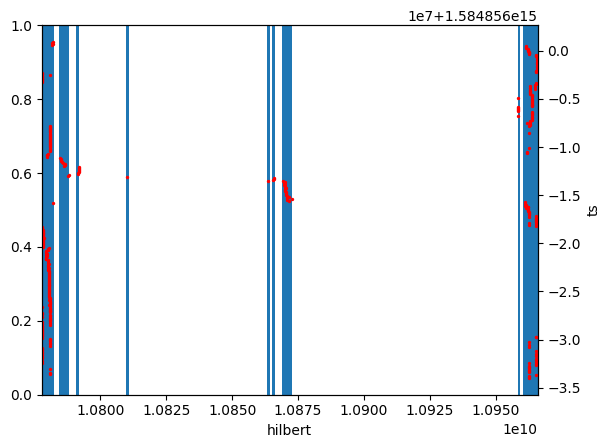

1584856011197903


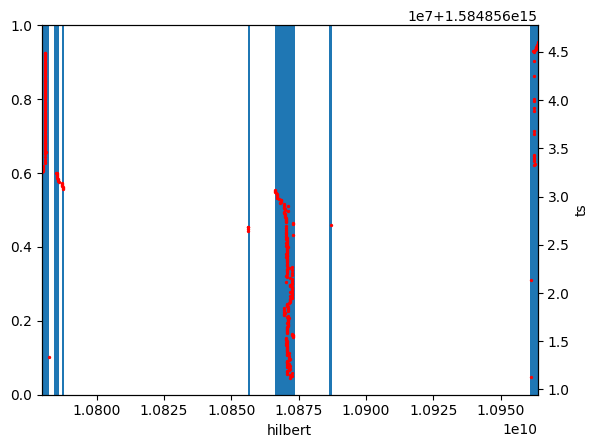

1584856056318970


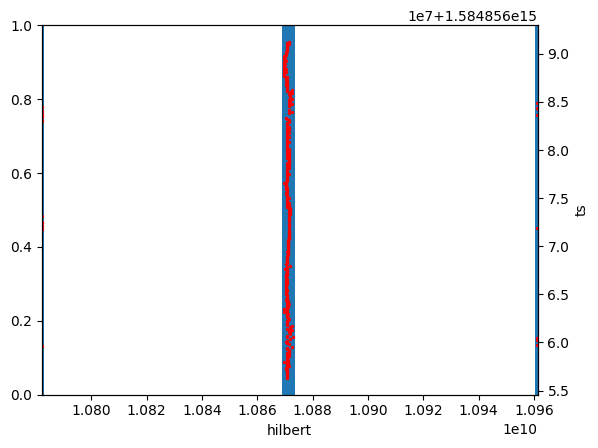

1584856101489818


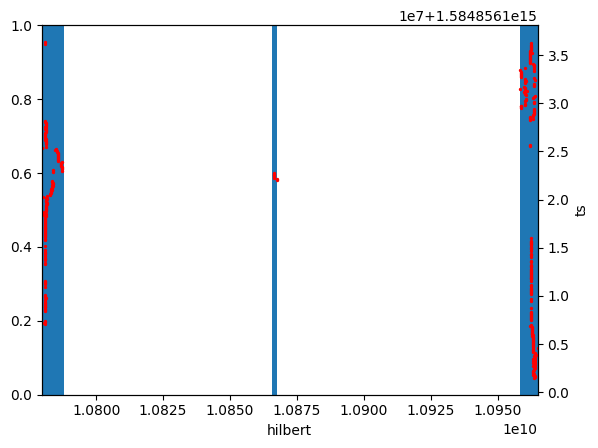

1584856146660421


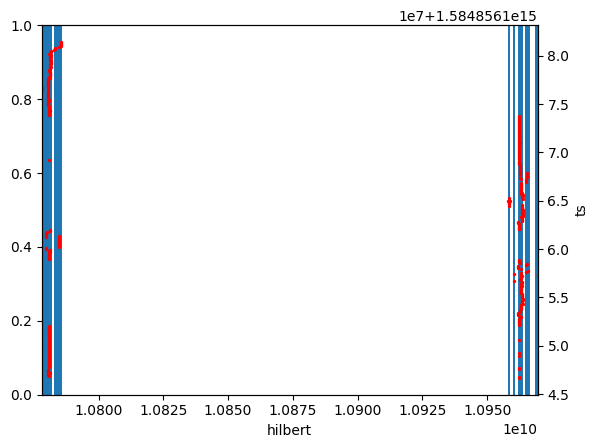

1584856191701431


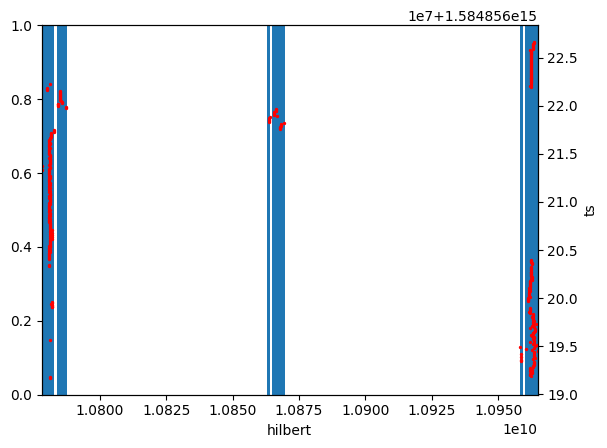

1584856236872030


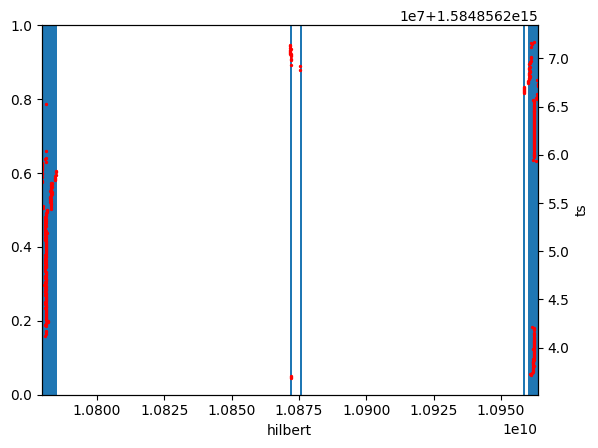

1584856281913012


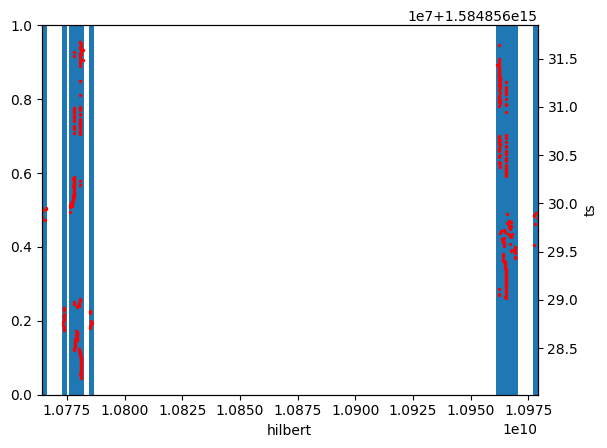

1584856327033887


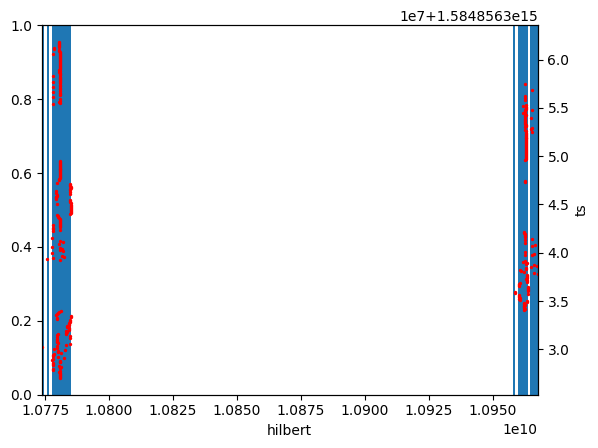

1584856372134647


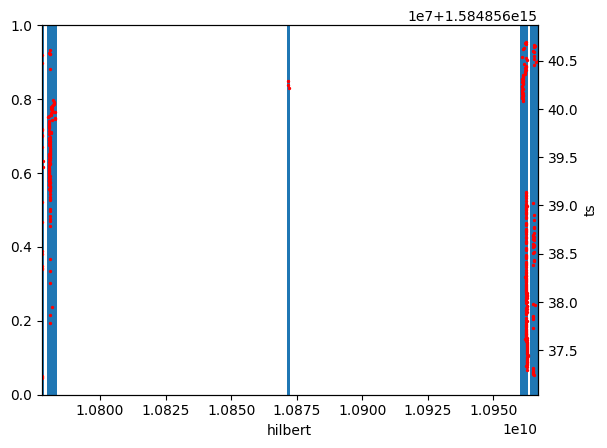

1584856417175187


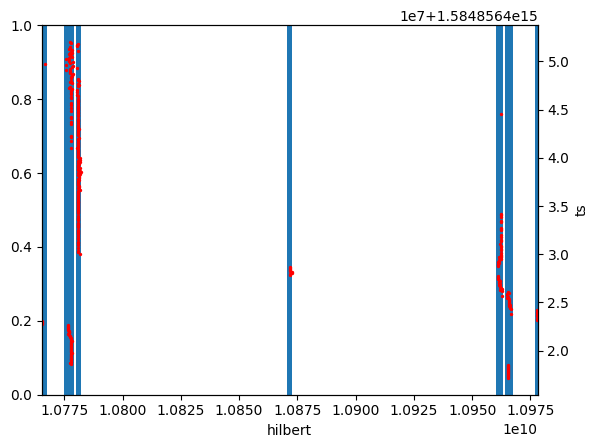

1584856462306255


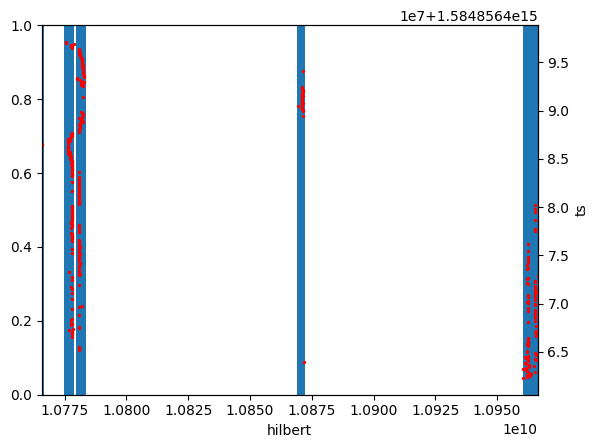

75


In [75]:
i = 0
roundabout_counter = 0
time_checker = 0
index_store = 0

while i < (acc_data_size - chunk_size) :
    
    sub_ra = acc_data_normalized.iloc[i:i+chunk_size, :]
    sub_hilbert = average_calculator(sub_ra, 'hilbert', 5)
    correlation = correlation_calculator(sub_hilbert, ref_norm_hilbert, 3)  
    
    if (correlation > 0.8) and index_store == (i-1):  # the pattern match the ref roundabout pattern
        
        time_checker += 1   
        index_store = i
       
        if time_checker > 100:
            roundabout_counter += 1
            print( acc_data['ts'][i])
#             plot_sfc_2d(sub_ra, 'hilbert')
            time_checker = 0
            ra_range_detector(acc_data['ts'][i]) 
            i += chunk_size
        else: 
            i += 1 

    else :  # the pattern is not a match
        index_store = i
        i += 1
        time_checker = 0
    
        
print(roundabout_counter)